In [1]:
from src.implementations import *

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.subplots as sp

import zipfile
import warnings

from scipy.stats import entropy

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go

from sklearn.manifold import TSNE, trustworthiness
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import Draw

from transformers import AutoTokenizer, AutoModel
import torch
import umap
import sys

In [2]:
# Ignore benign warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=UserWarning, module="umap")

# <b><u> Data Loading </u></b> #

We load only the relevant columns since the dataset is already quite large (3 million rows).

In [3]:
zip_file_path = 'data/BindingDB_All_202409_tsv.zip'
file_path = 'data/BindingDB_All.tsv'

list_columns_kept = ['Ligand SMILES', 'Target Name', 'Target Source Organism According to Curator or DataSource', 'Target Name', 'Institution', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)', 'pH', 'Temp (C)', 
                'Number of Protein Chains in Target (>1 implies a multichain complex)', 'BindingDB Target Chain Sequence', 'BindingDB Target Chain Sequence.1',
                'BindingDB Target Chain Sequence.2', 'BindingDB Target Chain Sequence.3', 'BindingDB Target Chain Sequence.4', 'BindingDB Target Chain Sequence.5',
                'BindingDB Target Chain Sequence.6', 'BindingDB Target Chain Sequence.7', 'BindingDB Target Chain Sequence.8', 'BindingDB Target Chain Sequence.9', 
                'BindingDB Target Chain Sequence.10', 'BindingDB Target Chain Sequence.11', 'BindingDB Target Chain Sequence.12']


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open('BindingDB_All.tsv') as file:
        data = pd.read_csv(file, sep='\t', usecols=list_columns_kept, na_values=['', 'NULL'])

data = pd.DataFrame(data)
data.head()

/var/folders/7z/y2p4cj3n02g7g064sxpd55380000gn/T/ipykernel_27072/308637278.py:13: DtypeWarning: Columns (8,9,10,11,12,13,15,23,50,62,74,86,98,110,122,134,146,158,170,182) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file, sep='\t', usecols=list_columns_kept, na_values=['', 'NULL'])


Ligand SMILES  \
0  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...   
1  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...   
2  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...   
3  OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...   
4  OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...   

                              Target Name  \
0  Dimer of Gag-Pol polyprotein [501-599]   
1  Dimer of Gag-Pol polyprotein [501-599]   
2  Dimer of Gag-Pol polyprotein [501-599]   
3  Dimer of Gag-Pol polyprotein [501-599]   
4  Dimer of Gag-Pol polyprotein [501-599]   

  Target Source Organism According to Curator or DataSource Ki (nM) IC50 (nM)  \
0                     Human immunodeficiency virus 1           0.24       NaN   
1                     Human immunodeficiency virus 1           0.25       NaN   
2                     Human immunodeficiency virus 1           0.41       NaN   
3                     Human immunodeficiency virus 1            0.8       NaN   
4                     Human immunodeficiency virus 1           0.99       NaN   

  Kd (nM) EC50 (nM) kon (M-1-s-1) koff (s-1)   pH  ...  \
0     NaN       NaN           NaN        NaN  5.5  ...   
1     NaN       NaN           NaN        NaN  5.5  ...   
2     NaN       NaN           NaN        NaN  5.5  ...   
3     NaN       NaN           NaN        NaN  5.5  ...   
4     NaN       NaN           NaN        NaN  5.5  ...   

  BindingDB Target Chain Sequence.3 BindingDB Target Chain Sequence.4  \
0                               NaN                               NaN   
1                               NaN                               NaN   
2                               NaN                               NaN   
3                               NaN                               NaN   
4                               NaN                               NaN   

   BindingDB Target Chain Sequence.5 BindingDB Target Chain Sequence.6  \
0                                NaN                               NaN   
1                                NaN                               NaN   
2                                NaN                               NaN   
3                                NaN                               NaN   
4                                NaN                               NaN   

  BindingDB Target Chain Sequence.7 BindingDB Target Chain Sequence.8  \
0                               NaN                               NaN   
1                               NaN                               NaN   
2                               NaN                               NaN   
3                               NaN                               NaN   
4                               NaN                               NaN   

  BindingDB Target Chain Sequence.9 BindingDB Target Chain Sequence.10  \
0                               NaN                                NaN   
1                               NaN                                NaN   
2                               NaN                                NaN   
3                               NaN                                NaN   
4                               NaN                                NaN   

  BindingDB Target Chain Sequence.11 BindingDB Target Chain Sequence.12  
0                                NaN                                NaN  
1                                NaN                                NaN  
2                                NaN                                NaN  
3                                NaN                                NaN  
4                                NaN                                NaN  

[5 rows x 26 columns]

# <b><u> Some Insight on Data </u></b> #

<b> The dataset is extensive and encompasses a wide range of organisms. Due to the computational limitations of our systems and the complexity of the data (e.g., SMILES strings and target chains), it is more practical to narrow our focus to a specific subset of organisms rather than processing the entire dataset. </b>

First, we check the number of proteins for each organism. Since we will be performing data cleaning, we will focus on organisms with high protein counts.

In [4]:
# Get the value counts in the organism column
col_name = 'Target Source Organism According to Curator or DataSource'
if col_name in data.columns:
    value_counts = data.groupby(col_name).size().sort_values(ascending=False)
print(value_counts[0:10])

Target Source Organism According to Curator or DataSource
Homo sapiens                      1541025
Rattus norvegicus                  109758
Mus musculus                        49854
Rattus                              33718
Human immunodeficiency virus 1      21780
Bos taurus                          17618
Electrophorus electricus             7921
Cavia porcellus                      7639
Cavia cutleri                        6540
Escherichia coli                     5651
dtype: int64


Studying complex organisms, such as mammals like Homo sapiens, is challenging due to their biological intricacy and the vast scope of diverse research areas (e.g., oncology, metabolism, genetic diseases). In contrast, virus research is primarily focused on neutralizing their virulence, making them more straightforward targets for analysis. This distinction guides our decision to focus on viruses as the target organisms for this study. Amongst the viruses, HIV-1, has the highest count. Hence we made a decision to focus on HIV. 

To justify it further, we compare the counts of different viruses and identify the institutions that studied them.

total number of virus associated protein: 42342


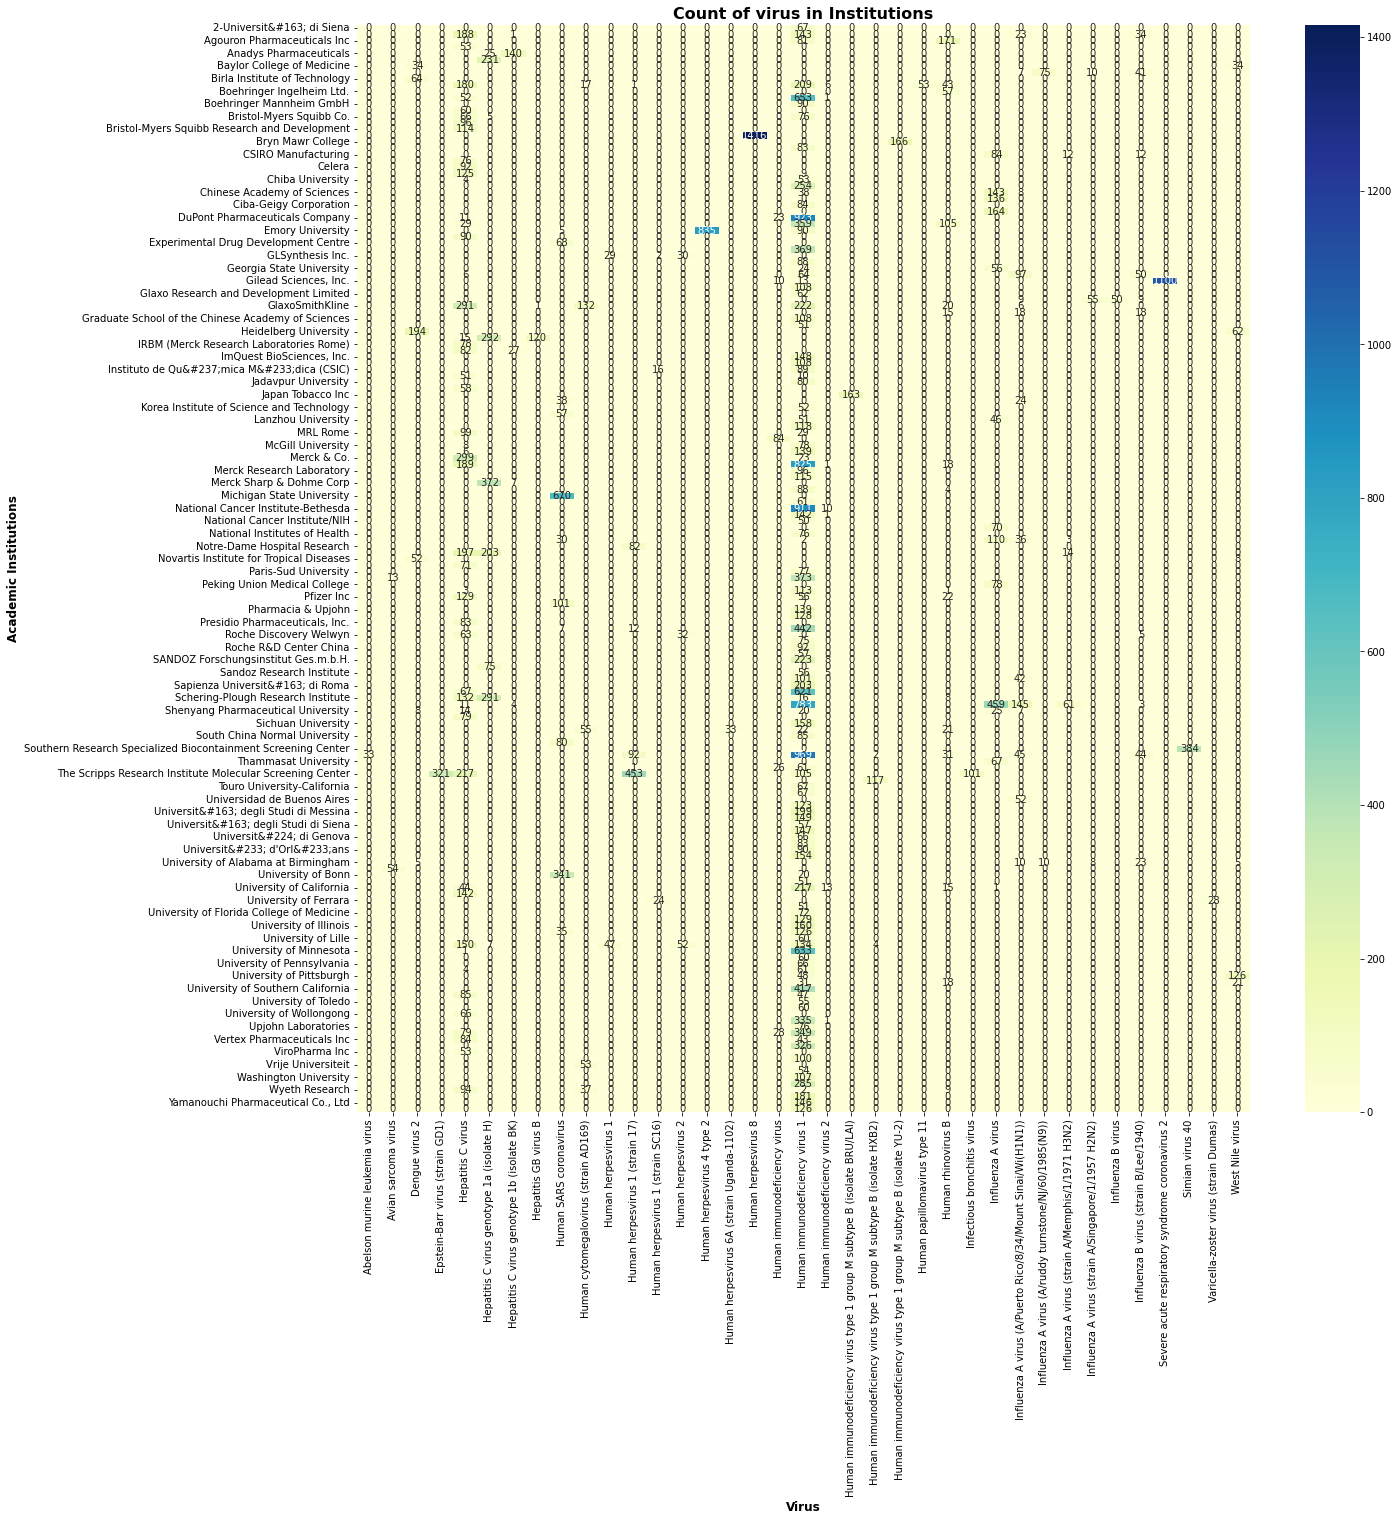

In [5]:
virus_data = data[data['Target Source Organism According to Curator or DataSource'].str.contains('virus', case=False, na=False)]

print(f'total number of virus associated protein: {virus_data["Target Source Organism According to Curator or DataSource"].value_counts().sum()}')

virus_counts = pd.crosstab(virus_data['Institution'], 
                           virus_data['Target Source Organism According to Curator or DataSource'])

virus_counts = virus_counts.loc[:, virus_counts.sum(axis=0) >= 50] 
virus_counts = virus_counts[virus_counts.sum(axis=1) >= 50]

plt.figure(figsize=(20, 20))
sns.heatmap(virus_counts, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Count of virus in Institutions', fontweight=800,fontsize=16)
plt.xlabel('Virus',fontweight=800,fontsize=12)
plt.ylabel('Academic Institutions', fontweight=800,fontsize=12)
plt.show()

In [6]:
import pandas as pd
import plotly.express as px

# Filter virus-related data
virus_data = data[data['Target Source Organism According to Curator or DataSource']
                  .str.contains('virus', case=False, na=False)]

# Total virus-associated proteins
total_proteins = virus_data["Target Source Organism According to Curator or DataSource"].value_counts().sum()
print(f'Total number of virus-associated proteins: {total_proteins}')

# Create a crosstab for virus counts
virus_counts = pd.crosstab(
    virus_data['Institution'],
    virus_data['Target Source Organism According to Curator or DataSource']
)

# Filter rows and columns with totals >= 50
filtered_counts = virus_counts.loc[:, virus_counts.sum(axis=0) >= 50]
filtered_counts = filtered_counts[filtered_counts.sum(axis=1) >= 50]

# Plotly heatmap
fig = px.imshow(
    filtered_counts,
    text_auto=True,  # Annotate cells with values
    color_continuous_scale="Viridis",  # Alternative color scheme for contrast
    labels=dict(x="Virus", y="Institution", color="Count"),
    title="Virus Count Across Institutions (Filtered)"
)

# Customize the layout for better clarity
fig.update_layout(
    title=dict(text="Count of Viruses in Institutions", x=0.5, font=dict(size=20)),
    xaxis=dict(
        title="Virus",
        tickangle=45,  # Rotate x-axis labels
        tickfont=dict(size=10)
    ),
    yaxis=dict(
        title="Institution",
        tickfont=dict(size=10)
    ),
    font=dict(size=12),
    width=2000,  # Set the width in pixels
    height=4000   # Set the height in pixels

)

# Show the interactive heatmap
fig.show()


Total number of virus-associated proteins: 42342


In [7]:
virus_data = data[data['Target Source Organism According to Curator or DataSource']
                  .str.contains('virus', case=False, na=False)]

# Count the occurrences of each virus
virus_counts = virus_data['Target Source Organism According to Curator or DataSource'].value_counts()

# Create a pie chart using Plotly
fig = px.pie(
    names=virus_counts.index,  # Virus names (labels)
    values=virus_counts.values,  # Count of occurrences
    title="Distribution of Viruses Across Institutions",
    labels={"names": "Virus", "values": "Count"},  # Labels for the chart
    hole=0.3  # To create a donut chart (optional)
)

fig.update_layout(
    title=dict(text="Distribution of Viruses Across Institutions", x=0.5, font=dict(size=20)),
    width=1000,  # Increase width
    height=1500,  # Increase height
)

# Show the pie chart
fig.show()


Among all viruses, HIV-1 is the only one with sufficient Ki data and is extensively studied by numerous labs. In contrast, the available Kd data is too sparse to be useful.

In [8]:
non_nan_ki = virus_data['Ki (nM)'].count()
print('Numbers of data containing Ki information (all viruses): ', non_nan_ki)

non_nan_kd = virus_data['Kd (nM)'].count()
print('Numbers of data containing Kd information (all viruses): ', non_nan_kd)

Numbers of data containing Ki information (all viruses):  6415
Numbers of data containing Kd information (all viruses):  406


In [9]:
hiv_data = data[data['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1'].reset_index(drop=True)

non_nan_ki = hiv_data['Ki (nM)'].count()
print('Numbers of data containing Ki information (Hiv1): ', non_nan_ki)

non_nan_kd = hiv_data['Kd (nM)'].count()
print('Numbers of data containing Kd information (Hiv1): ', non_nan_kd)

Numbers of data containing Ki information (Hiv1):  4350
Numbers of data containing Kd information (Hiv1):  237


# <b><u> Focusing on HIV-1 </u></b> #

<b> Here we check if HIV-1 data is sufficient and viable to train a machine learning model. </b>

Some data rows contain Ki values like '<100' or '>30000', which are difficult to interpret. Therefore, we choose to drop these rows.

In [10]:
# Choosing the metric which is the most present
metric = 'Ki (nM)'

# Filter for Hiv1
hiv_data = data[data['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1'].reset_index(drop=True)
print(f'prior size: {hiv_data.shape[0]}')

mask_invalid_values = hiv_data[metric].str.contains('<',case=False,na=False) | hiv_data[metric].str.contains('>',case=False,na=False) | hiv_data[metric].isna()
print(f'final size: {hiv_data.shape[0] - mask_invalid_values.sum()}')
hiv_data = hiv_data[~mask_invalid_values]

prior size: 21780
final size: 4171


Let's check the distribution of Ki. Ideally, it should be diverse to train a machine learning model.

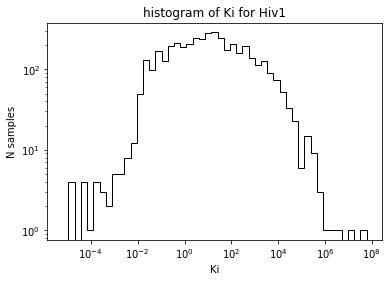

In [11]:
metric_numeric = pd.to_numeric(hiv_data[metric], errors='coerce').dropna()
bins = np.logspace(np.log10(metric_numeric.min()), np.log10(metric_numeric.max()), 50)
plt.hist(metric_numeric, bins=bins, edgecolor="black", histtype="step", log=True)

plt.xscale('log')
plt.title('histogram of Ki for Hiv1')
plt.xlabel('Ki')
plt.ylabel('N samples')
plt.show()

The data contains duplicate ligands and targets. For the machine learning model, it would be best to start by training on a single abundant unique target to refine the model and then gradually incorporate the complexity of multitarget learning. Additionally, it is important to ensure diversity among the proteins, as we would like the model to generalize better.

In [12]:
hiv_institution_counts = hiv_data['Institution'].value_counts()

# Get the institution with the most occurrences
most_active_institution = hiv_institution_counts.idxmax()
most_active_institution_count = hiv_institution_counts.max()

print(f"The institution working the most with Human Immunodeficiency Virus 1 is: {most_active_institution}")
print(f"Number of records: {most_active_institution_count}")

The institution working the most with Human Immunodeficiency Virus 1 is: DuPont Pharmaceuticals Company
Number of records: 729


Number of Ligand compounds in HIV1:  5638


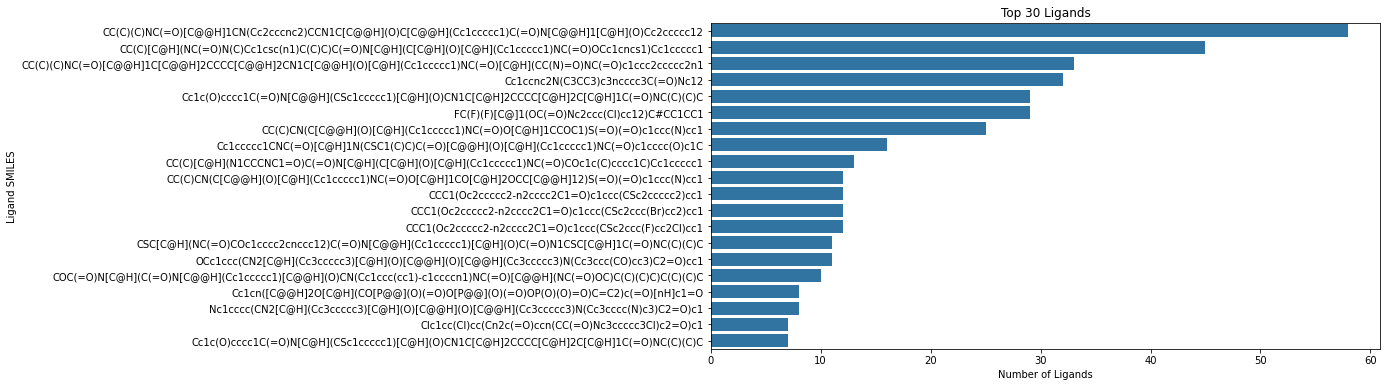

In [13]:
target_counts = hiv_data.groupby('Ligand SMILES').size().reset_index(name='Compound Count')

target_counts = target_counts.sort_values(by='Compound Count', ascending=False)
print('Number of Ligand compounds in HIV1: ', target_counts.size)

plt.figure(figsize=(12, 6))
sns.barplot(x='Compound Count', y='Ligand SMILES', data=target_counts.head(20))
plt.title('Top 30 Ligands')
plt.xlabel('Number of Ligands')
plt.ylabel('Ligand SMILES')
plt.show()

Number of targets of the compounds in HIV1:  126


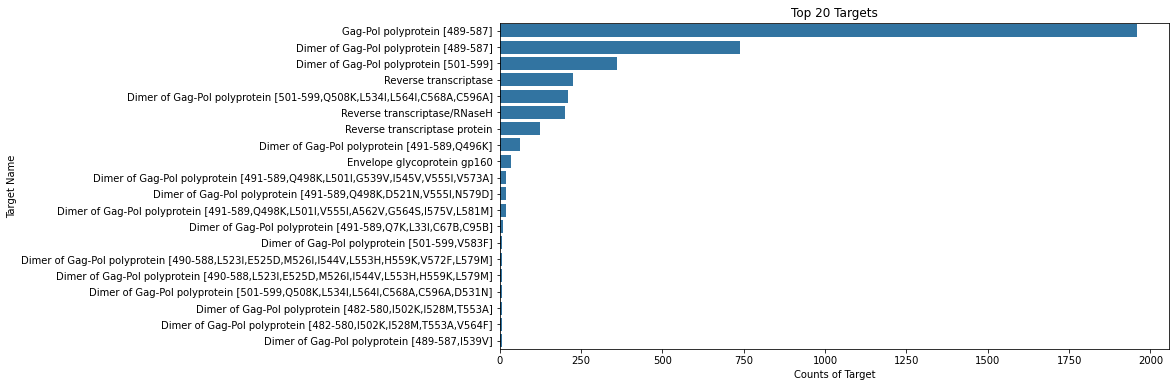

In [14]:
# Check the targets for Hiv1
target_counts = hiv_data.groupby('Target Name').size().reset_index(name='Compound Count')

target_counts = target_counts.sort_values(by='Compound Count', ascending=False)
print('Number of targets of the compounds in HIV1: ', target_counts.size)

plt.figure(figsize=(12, 6))
sns.barplot(x='Compound Count', y='Target Name', data=target_counts.head(20))
plt.title('Top 20 Targets')
plt.xlabel('Counts of Target')
plt.ylabel('Target Name')
plt.show()

Some targets consist of multiple chains, which we need to account for in the machine learning model. We could either concatenate the chains of such targets and treat them as a single entity or handle them as separate parameters. This has not yet been decided.

In [15]:
col_name = 'Number of Protein Chains in Target (>1 implies a multichain complex)'
seq_col = 'BindingDB Target Chain Sequence'

if col_name in hiv_data.columns and seq_col in hiv_data.columns:
    unique_data = hiv_data.drop_duplicates(subset=[seq_col])
    count_Nchain = unique_data[col_name].value_counts()

count_Nchain

Number of Protein Chains in Target (>1 implies a multichain complex)
1    56
2     7
Name: count, dtype: int64

# <u><b>CLUSTERING</b></u>

<b> To train a machine learning model, we must provide it with numerical data. For ligands, the only relevant information available is SMILES strings. Additionally, the data needs to be suitable for training, with data points that are differentiable.

To obtain continuous data, we first embed the SMILES using one of two algorithms: BERT embedding (using ChemBERTa) or Morgan Fingerprint.

Next, for visualisation purposes and due to computational constraints, we reduce the dimensionality of the data to three using two algorithms: t-SNE or UMAP. Both algorithms have their advantages and disadvantages. (We initially tried out PCA but we were not getting any good results, hence we decided to try better suited algorithms, hence t-SNE and UMAP.)

To draw final conclusions, we perform k-means clustering on the four combinations (BERT+t-SNE, BERT+UMAP, Morgan Fingerprint+t-SNE, Morgan Fingerprint+UMAP). We visually and numerically evaluate the best clusters with scores (silhouette score, Kullback-Leibler divergence for t-SNE, trustworthiness score for UMAP and normalized entropy). Clear, well-separated and balanced clusters are preferred. </b>

## <b>Clustering with Morgan Fingerprints: </b> ##

Advantages:

- The embedding is based on the environment of each atom (the surrounding atoms), providing a direct connection to the molecular structure.
- Produces a fixed vector size for each molecule, which can aid in clustering.
- Well-established and widely tested.

Inconveniences:

- Captures either local or global structures, depending on the radius (a hyperparameter) of the atom environments.
- Better suited for classification tasks; however, dimensionality reduction can mitigate this limitation.
- Highly sensitive to the radius parameter. If the radius is too large or too small, it can result in either overly sparse clusters or clusters that are difficult to differentiate.

More info on Morgan Fingerprints can be found in the implementation of [RDKit](https://github.com/rdkit/rdkit), and our implementations.py file.

Note: for dimension reduction of Morgan Fingerprints, we will use jaccard metric as it is suited for binary vectors

In [16]:
smiles_list = hiv_data['Ligand SMILES'].unique().tolist()

### Using TSNE: Generate Fingerprints + Compute and Plot Scores ###

Here and for each of subsequent combinations, we will evaluate the best number of clusters for k-means based on elbow method and silhouette score.

Radius = 2
Perplexity = 5


/Users/leonardotredici/opt/anaconda3/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning:


Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md




Perplexity = 20


KeyboardInterrupt: 

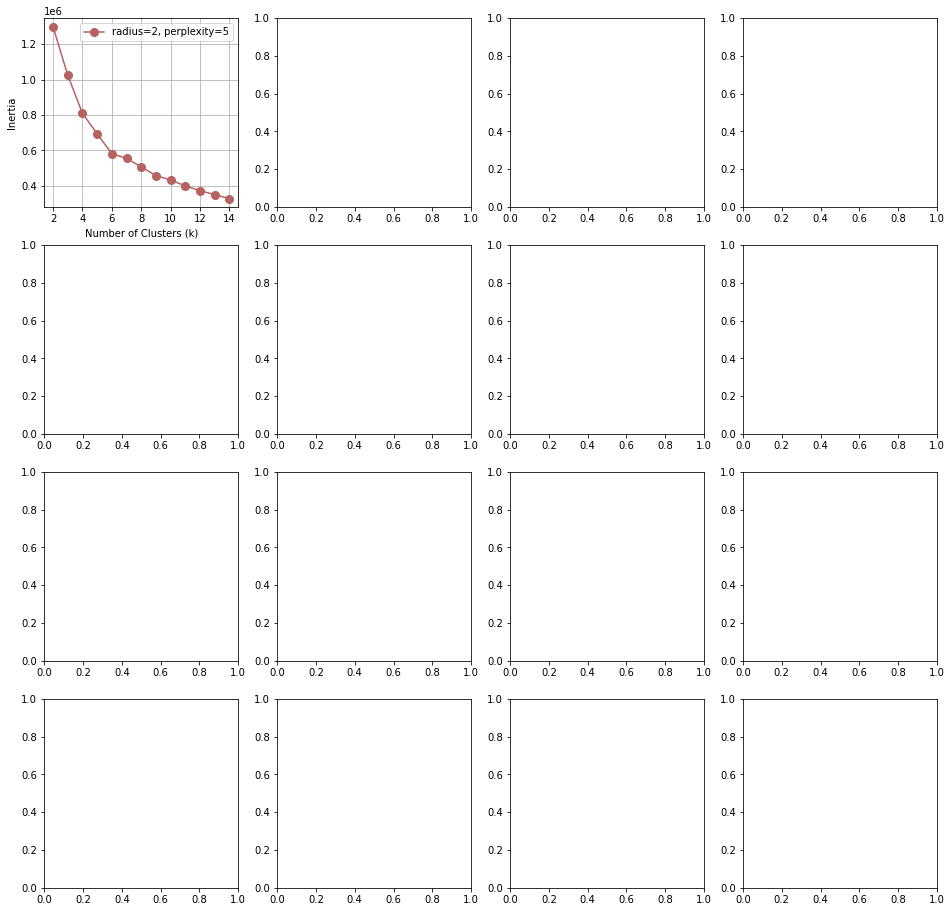

In [17]:
# For t-SNE, an important parameter to tune is perplexity (effective number of neighbors).
# We also tune the radius for Morgan Fingerprints

radiuses = [2,3,4,5]
perplexities = [5,20,35,50]
Ks = range(2, 15)
nrows, ncols = len(radiuses), len(perplexities)

tsn_results, KLs, s_scores = plot_elbow_curve(
    method='tsne',
    original_data=smiles_list,
    param1_list=radiuses,
    param2_list=perplexities,
    Ks=Ks,
    param1_name='radius',
    param2_name='perplexity',
    metric='jaccard',
    generate_MF=True
)

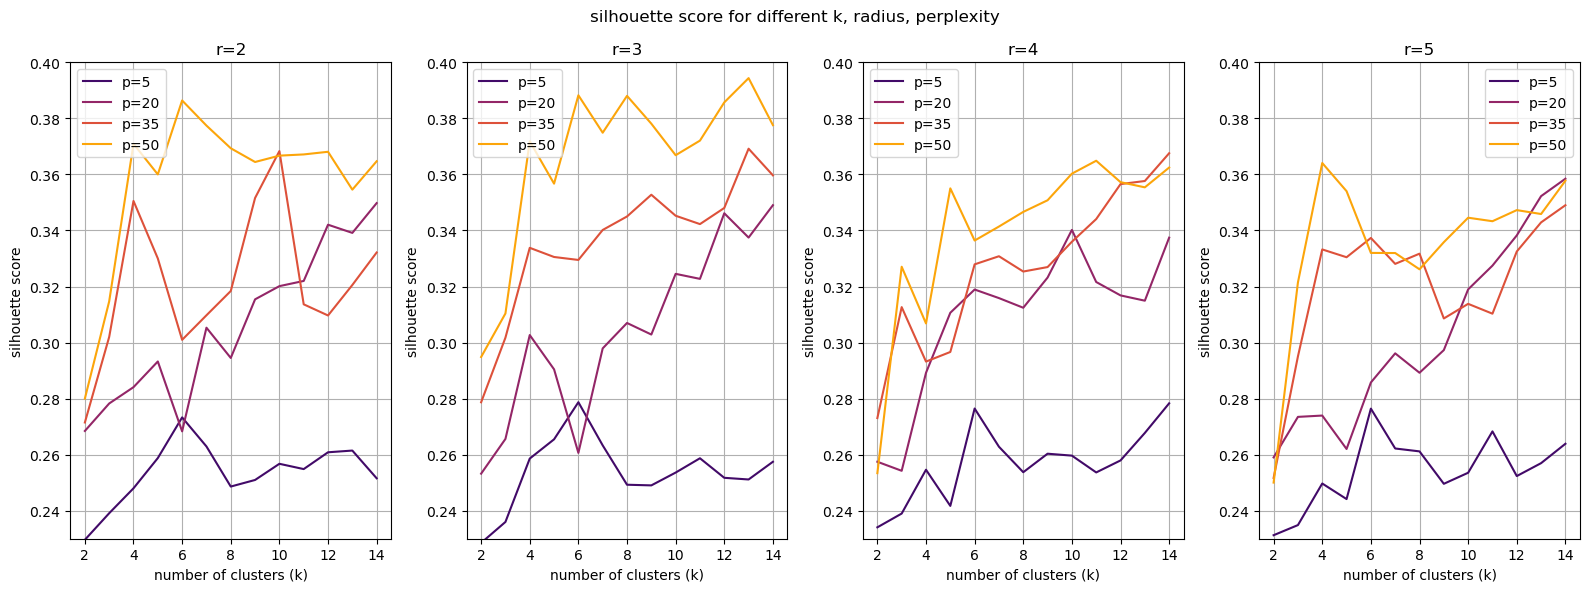

In [ ]:
plot_silhouette_scores(
    s_scores, Ks, radiuses, perplexities, 
    param1_name='r', param2_name='p', y_lim=(0.23, 0.4),
    color_palette="inferno", title="silhouette score for different k, radius, perplexity"
)

### Choosing best clusters from plots + Observing according distributions ###

Here, we first choose the best k for each combination manually and then plot the distribution of the clusters. The normalized entropy score is used to evaluate good distributions across the clusters (see implementations to have more info on this metric).

In [ ]:
# Choose best k for each radius and perplexity based on the graphs (not always clearly defined for some) (above 12 is excessive)
best_ks = [[6,12,10,6],
           [6,12,9,6],
           [6,10,12,11],
           [6,12,6,4]]

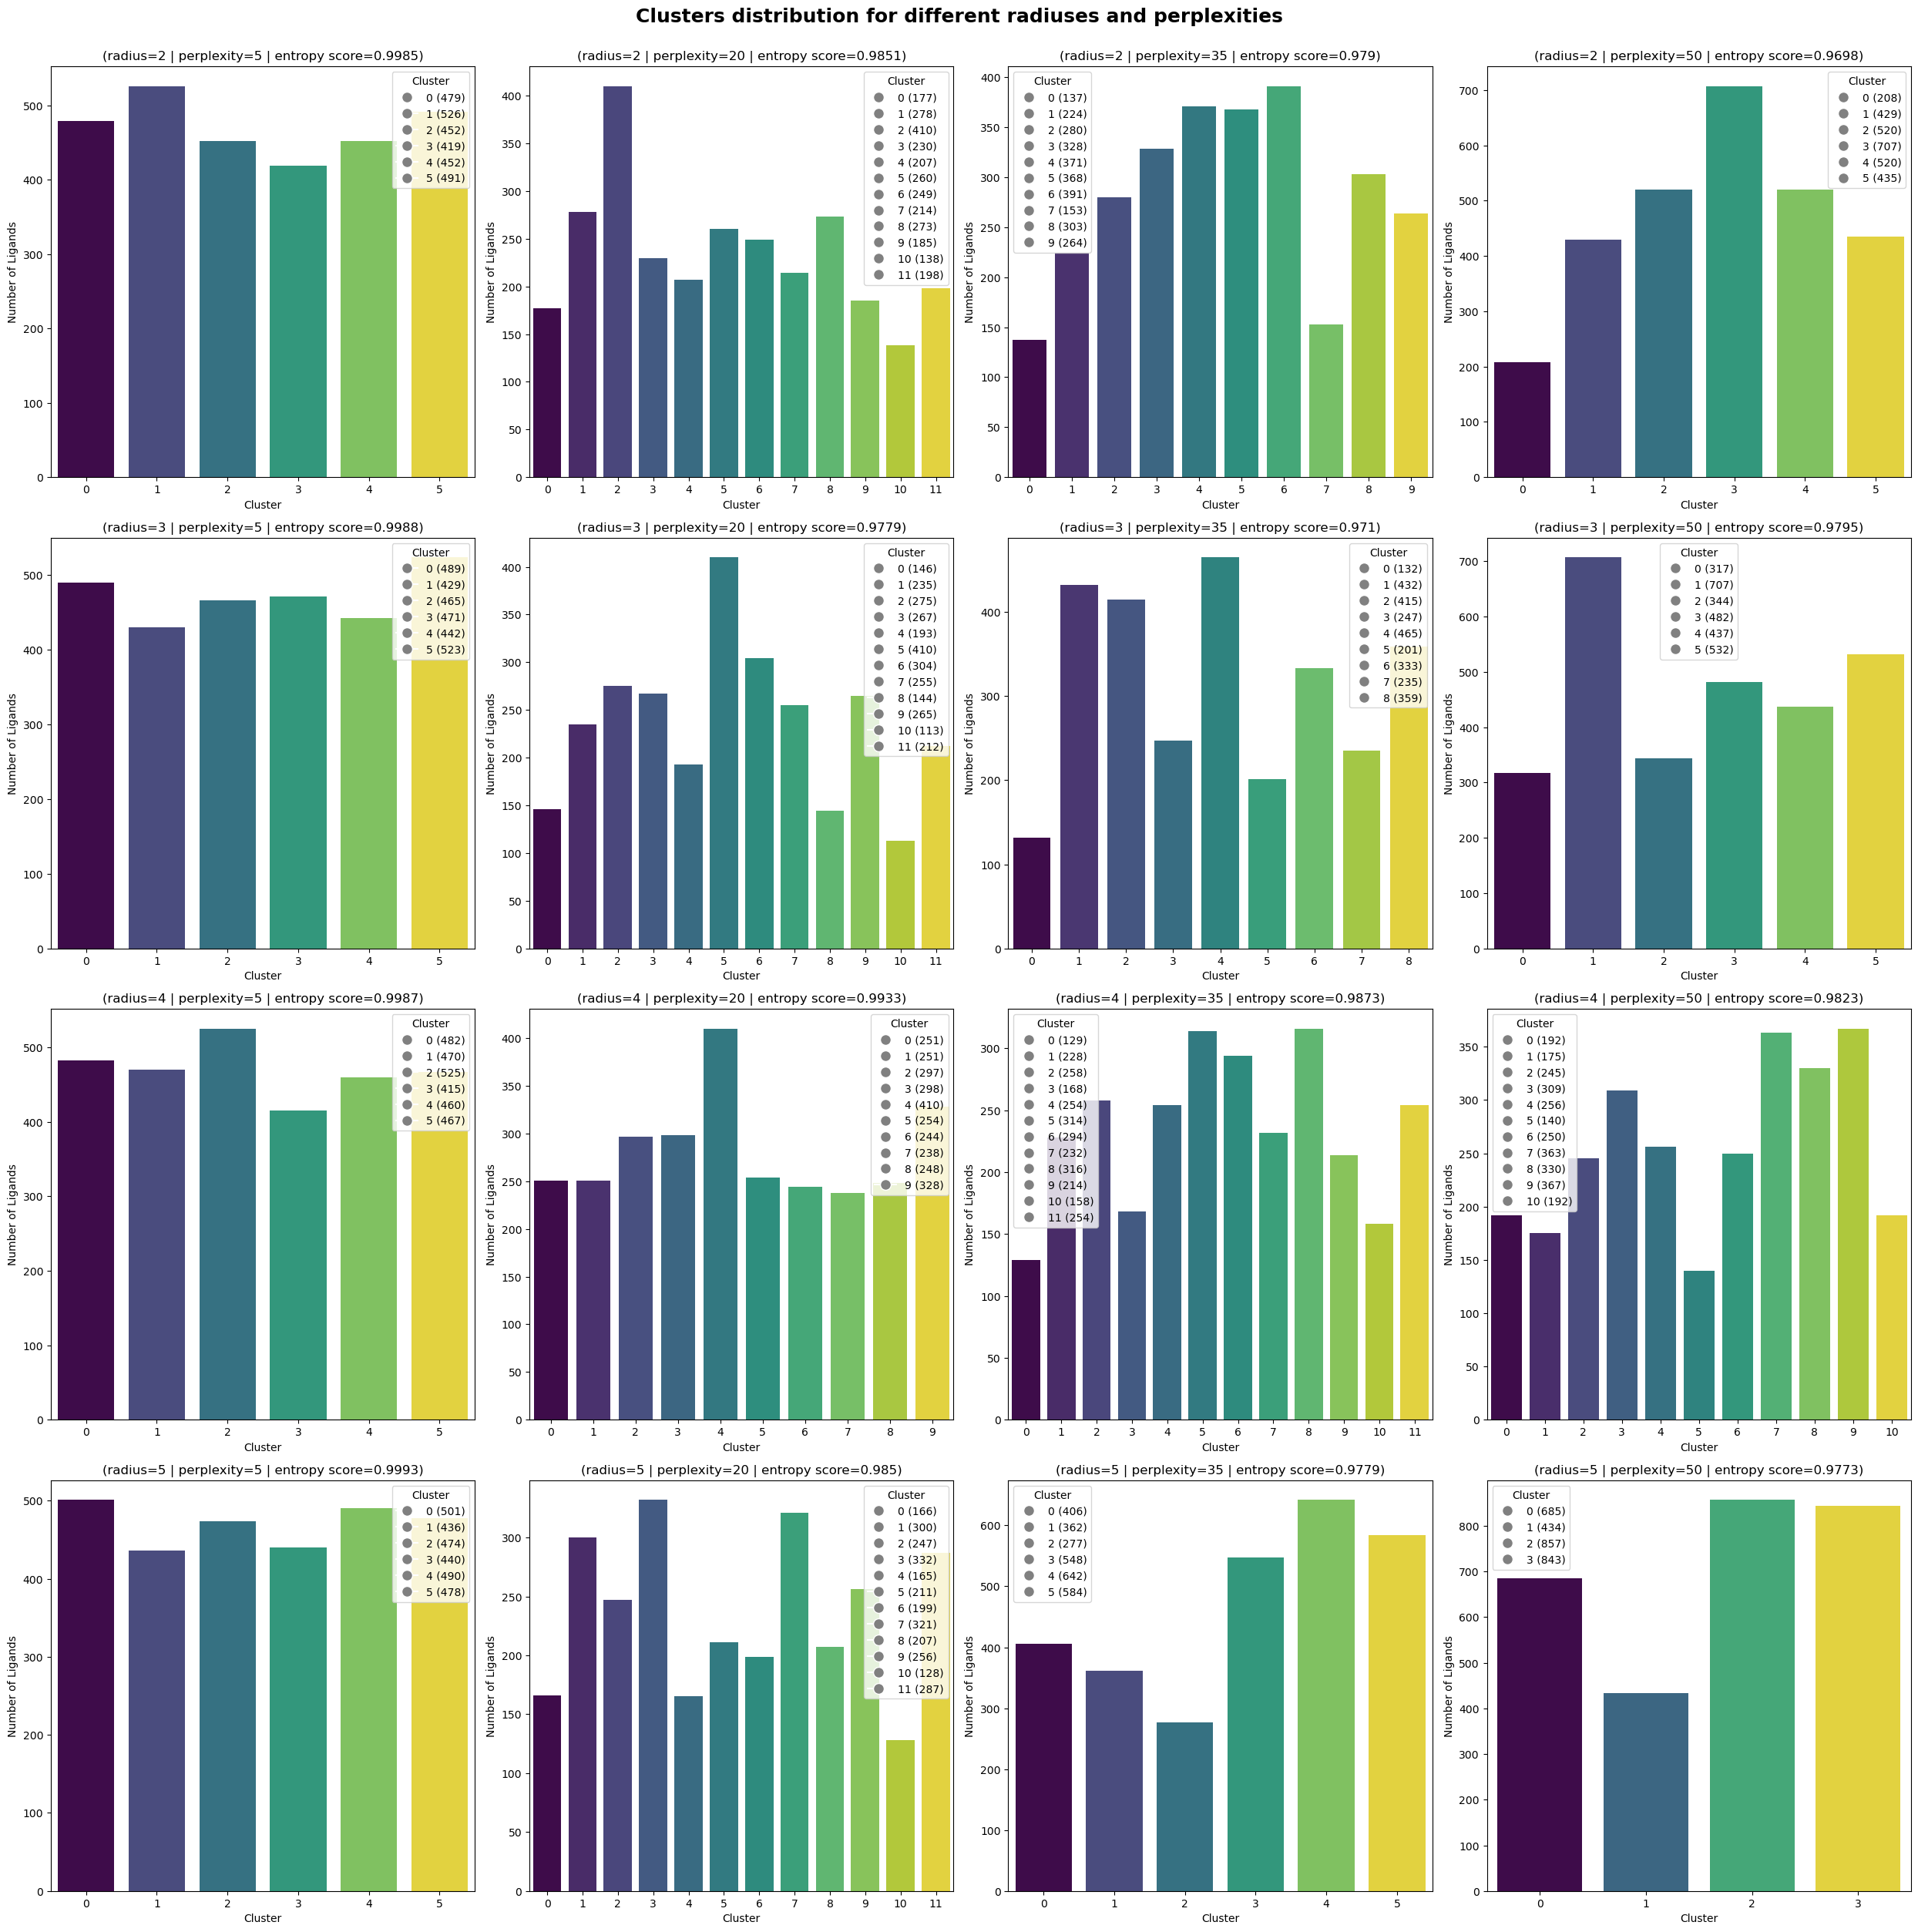

In [ ]:
plot_cluster_distributions(
    results=tsn_results, best_ks=best_ks, param1_values=radiuses, param2_values=perplexities,
    param1_name='radius', param2_name='perplexity',
    title="Clusters distribution for different radiuses and perplexities"
)

#### Choose best cluster according to KL metric and check them in reduced spatial representation ####

In [ ]:
best_r = 0
best_p = 0
best_kl = 100.0
for idx_r in range(nrows):
    for idx_p in range(ncols):
        print(f'radius: {radiuses[idx_r]} | perplexity: {perplexities[idx_p]} | KL score: {KLs[idx_r][idx_p]}')
        if KLs[idx_r][idx_p] < best_kl:
            min_index = (idx_r,idx_p)
            best_kl = KLs[idx_r][idx_p]
            best_r = radiuses[idx_r]
            best_p = perplexities[idx_p]

radius: 2 | perplexity: 5 | KL score: 0.552417516708374
radius: 2 | perplexity: 20 | KL score: 0.47736045718193054
radius: 2 | perplexity: 35 | KL score: 0.45127904415130615
radius: 2 | perplexity: 50 | KL score: 0.45064041018486023
radius: 3 | perplexity: 5 | KL score: 0.5536050200462341
radius: 3 | perplexity: 20 | KL score: 0.47465646266937256
radius: 3 | perplexity: 35 | KL score: 0.4576427936553955
radius: 3 | perplexity: 50 | KL score: 0.45243561267852783
radius: 4 | perplexity: 5 | KL score: 0.5375213623046875
radius: 4 | perplexity: 20 | KL score: 0.46273958683013916
radius: 4 | perplexity: 35 | KL score: 0.46268394589424133
radius: 4 | perplexity: 50 | KL score: 0.46262767910957336
radius: 5 | perplexity: 5 | KL score: 0.5201210975646973
radius: 5 | perplexity: 20 | KL score: 0.4685295820236206
radius: 5 | perplexity: 35 | KL score: 0.46512728929519653
radius: 5 | perplexity: 50 | KL score: 0.47749006748199463


In [ ]:
MANUAL_INDEX = False

if MANUAL_INDEX:
    min_index = (0,3)
    best_kl = KLs[min_index[0]][min_index[1]]
    best_r = radiuses[min_index[0]]
    best_p = perplexities[min_index[1]]

k = best_ks[min_index[0]][min_index[1]]

In [ ]:
print(f'Our best hyperparameters is: Radius of {best_r}, Perplexity of {best_p} with KL Divergence of {best_kl}')

Our best hyperparameters is: Radius of 2, Perplexity of 50 with KL Divergence of 0.45064041018486023


In [ ]:
TSNE_MF_df = plot_3d_clusters(tsn_results, min_index, k, method_name='TSNE')

In the case the 3D interactive plot does not render (if you are not using VSCode), below is a saved image of the plot:

![3D plot of Morgan Fingerprint clustering using t-SNE dimension reduction](test/TSNE_MF.png)

### Using UMAP: Generate Fingerprints + Compute and Plot Scores ###

N_neighbors = 15
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 25
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 50
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 100
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6


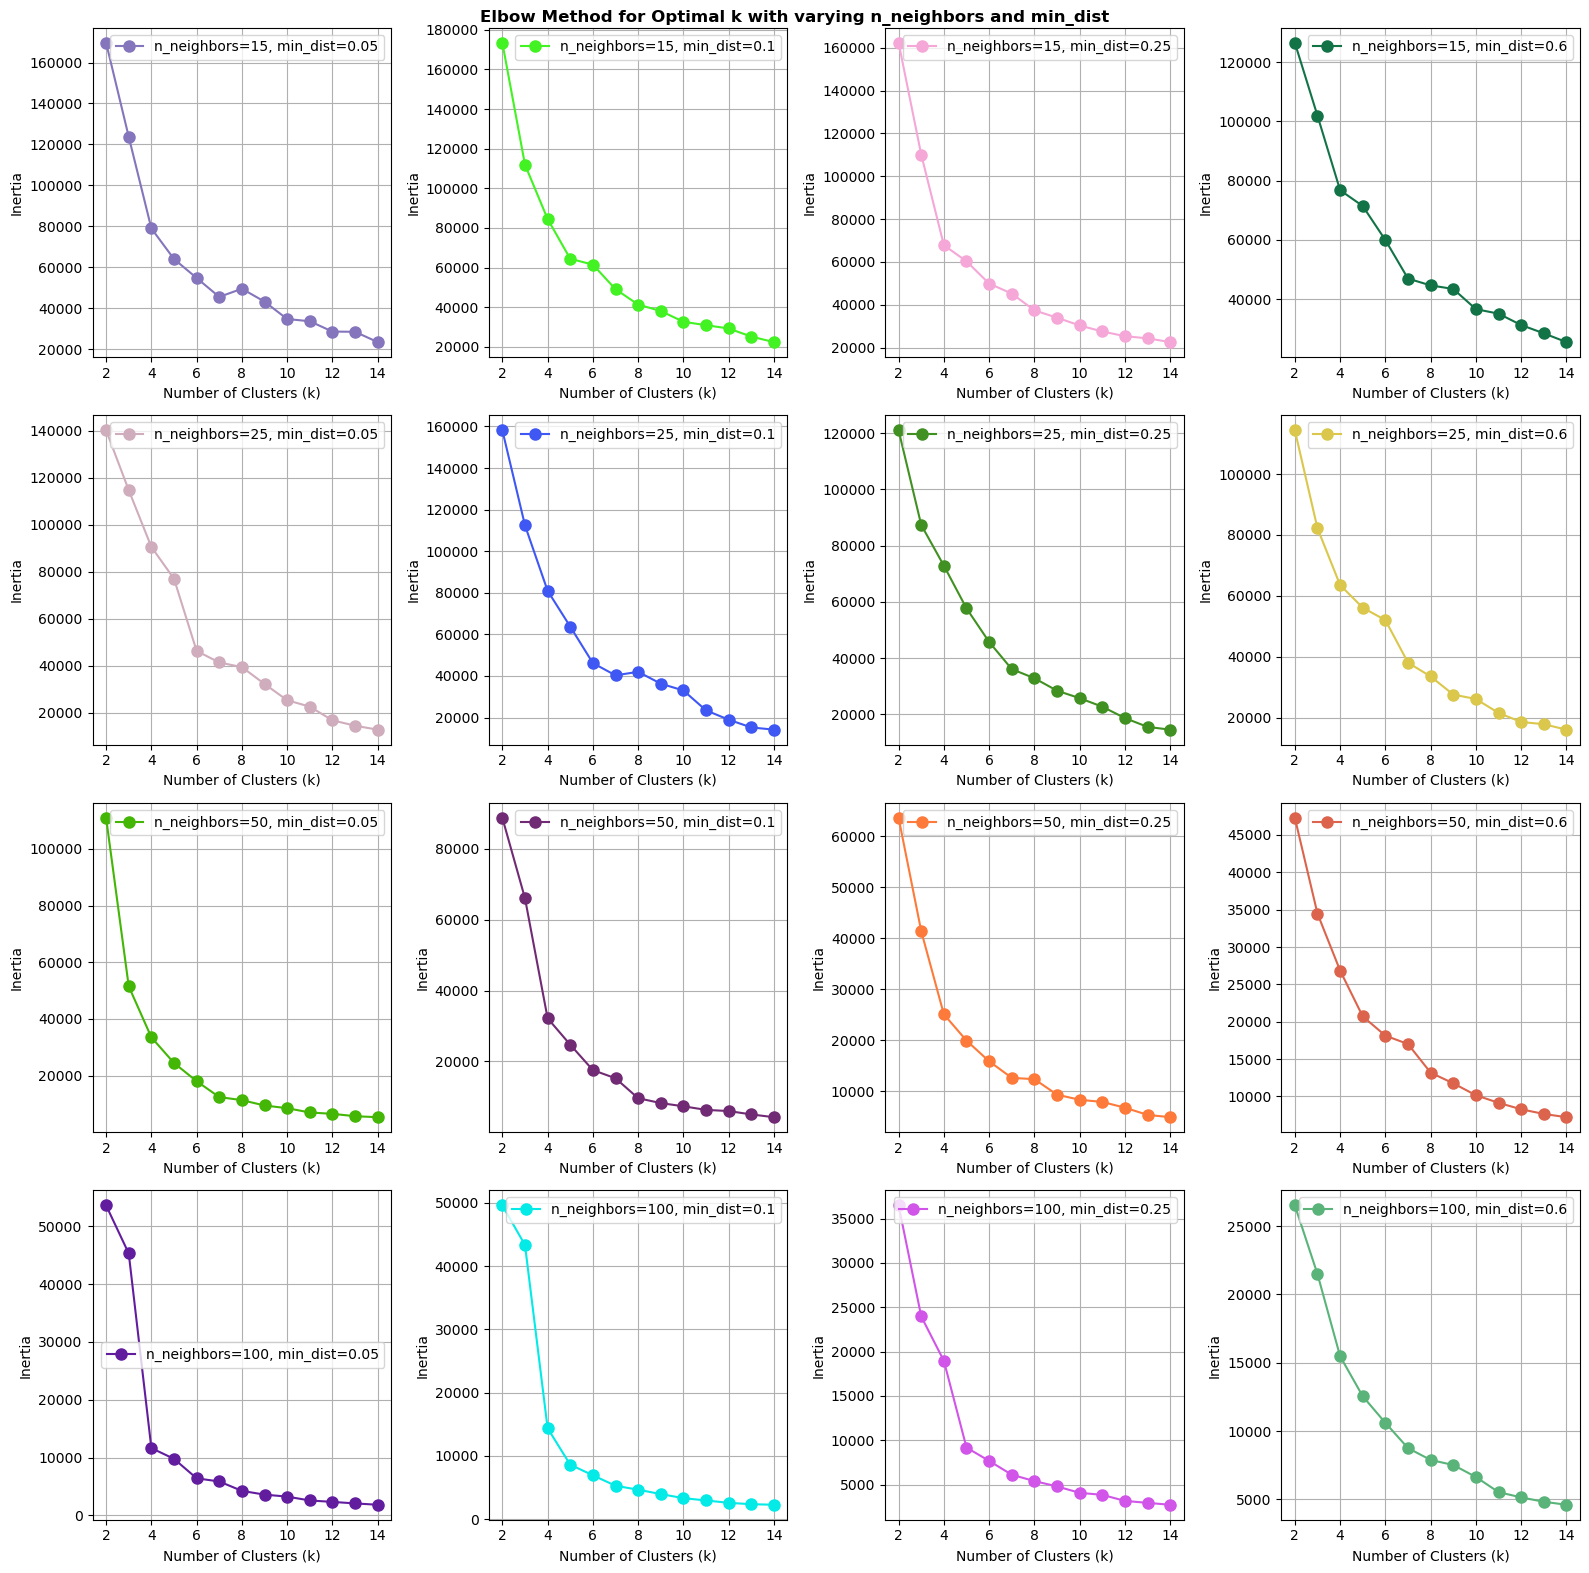

In [ ]:
# Important parameters for UMAP are the minimum number of neighbors and the minimum distance between neighbors.
# We don't tune the radius for Morgan Fingerprints as this would clutter the analysis. Instead we take the one that performed best
# in t-SNE (default is put to 3 in the implementations)

l_n_neighbors = [15,25,50,100]
min_dists = [0.05,0.1,0.25,0.6]
nrows, ncols = len(l_n_neighbors), len(min_dists)
Ks = range(2, 15)

umap_results, trust_scores, s_scores = plot_elbow_curve(
    method='umap',
    original_data=smiles_list,
    param1_list=l_n_neighbors,
    param2_list=min_dists,
    Ks=Ks,
    param1_name='n_neighbors',
    param2_name='min_dist',
    metric='jaccard',
    generate_MF=True
)

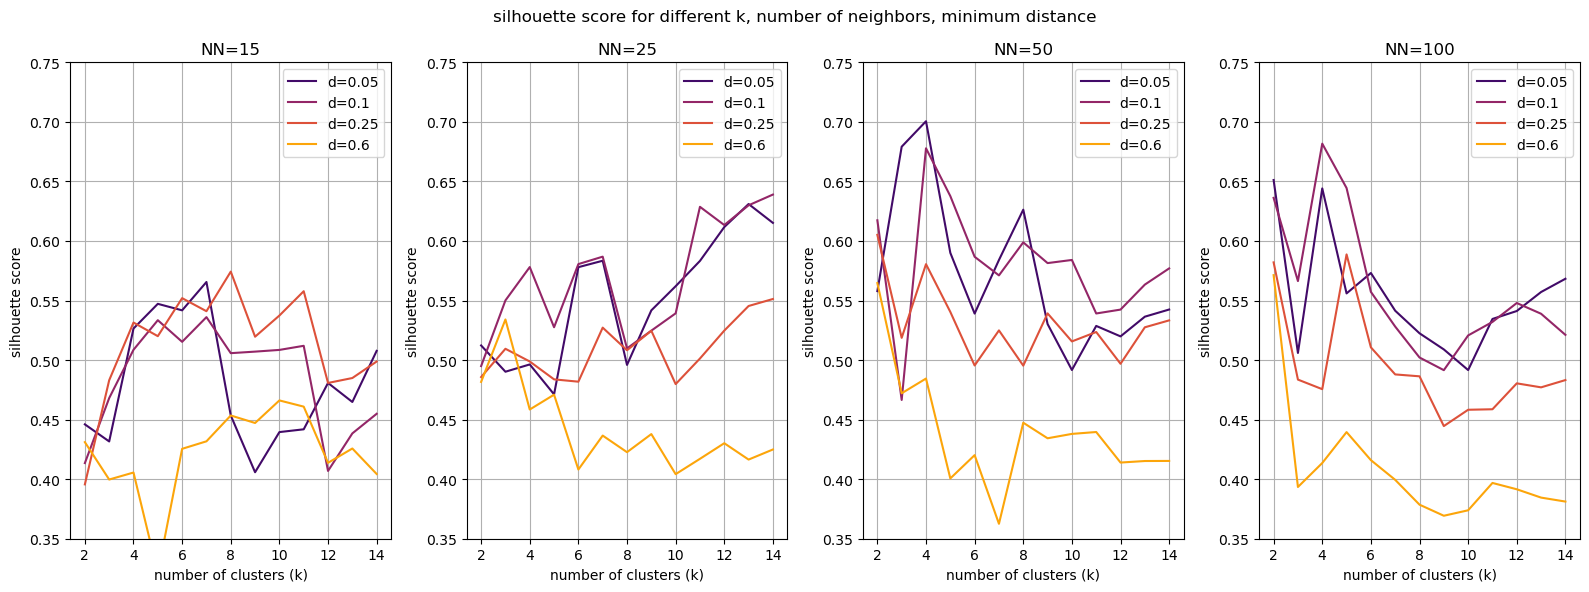

In [ ]:
plot_silhouette_scores(
    s_scores, Ks, l_n_neighbors, min_dists, 
    param1_name='NN', param2_name='d', y_lim=(0.35, 0.75),
    color_palette="inferno", title="silhouette score for different k, number of neighbors, minimum distance"
)

In [ ]:
# Choose best k for each number of neighbors and minimum distance based on the graphes (not always clearly defined for some) (above 12 is excessive)
best_ks = [[7,6,5,11],
           [12,3,5,4],
           [4,4,4,2],
           [4,4,4,2]]

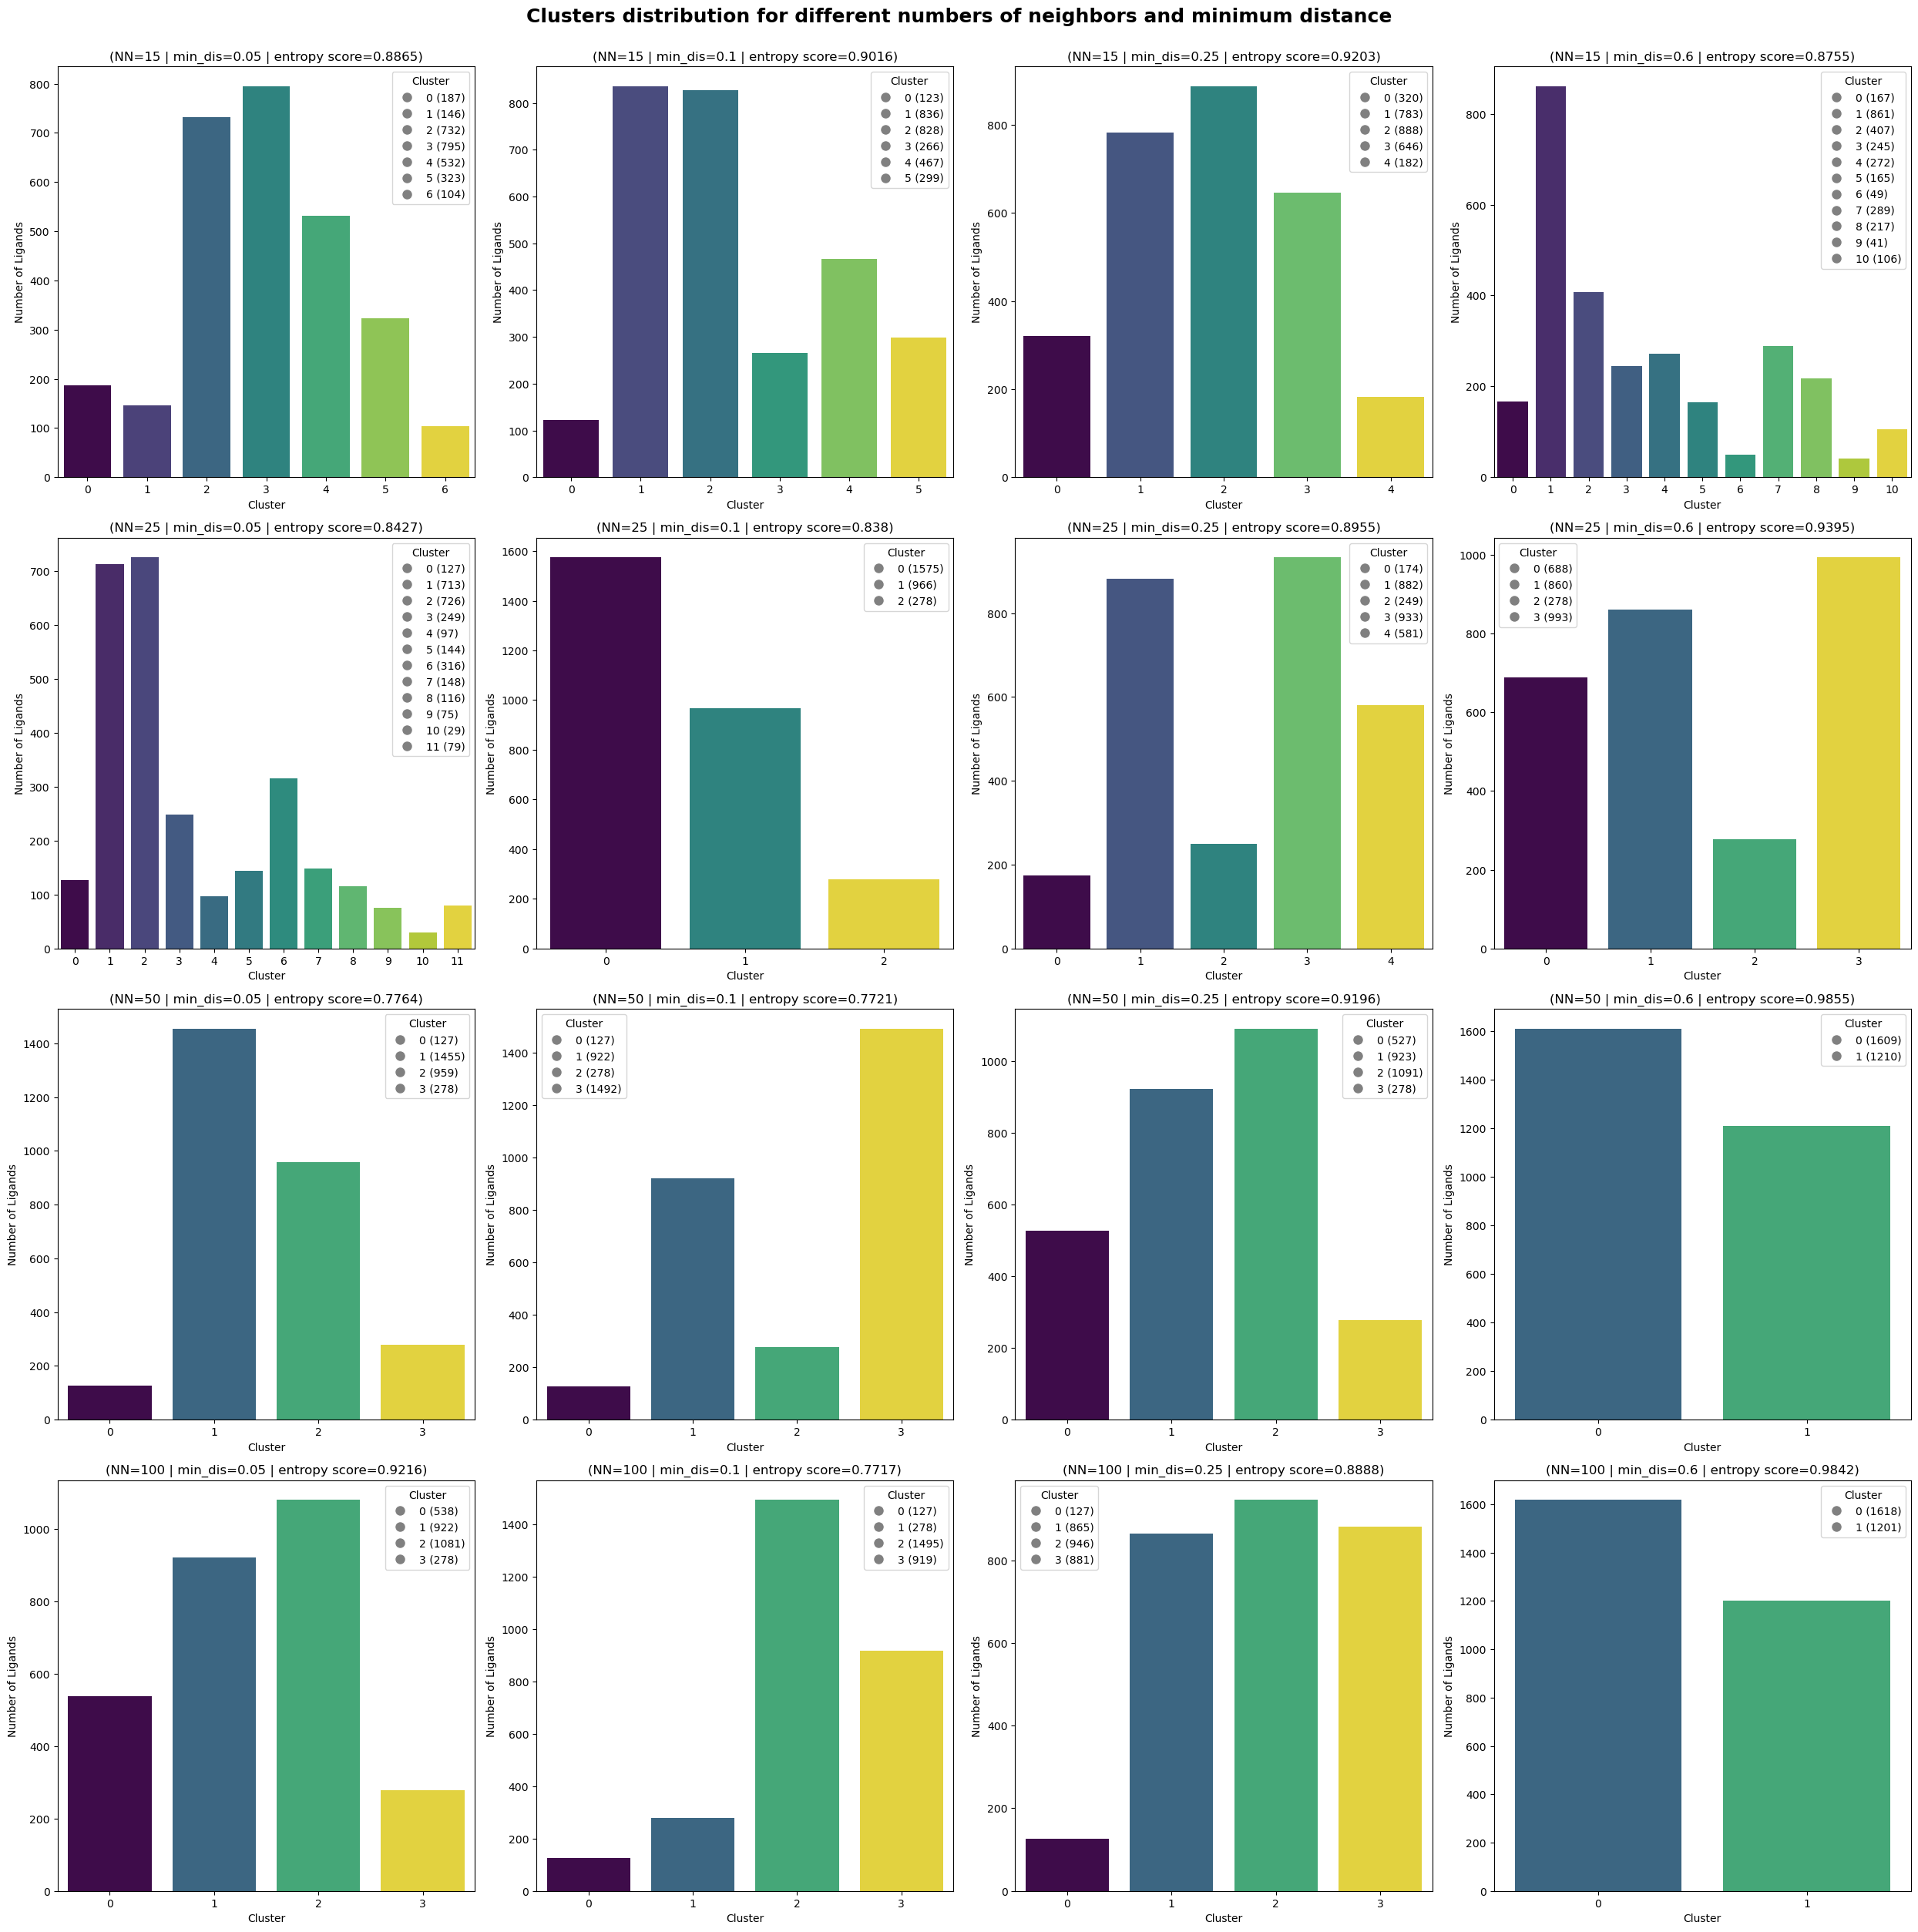

In [ ]:
plot_cluster_distributions(
    results=umap_results, best_ks=best_ks, param1_values=l_n_neighbors, param2_values=min_dists,
    param1_name='NN', param2_name='min_dis',
    title="Clusters distribution for different numbers of neighbors and minimum distance"
)

In [ ]:
best_NN = 0
best_d = 0
best_trust = 0
for idx_n in range(nrows):
    for idx_d in range(ncols):
        print(f'number of neighbors: {l_n_neighbors[idx_n]} | minimum distance: {min_dists[idx_d]} | trust score: {trust_scores[idx_n][idx_d]}')
        if trust_scores[idx_n][idx_d] > best_trust:
            min_index = (idx_n,idx_d)
            best_kl = trust_scores[idx_n][idx_d]
            best_NN = l_n_neighbors[idx_n]
            best_d = min_dists[idx_d]

number of neighbors: 15 | minimum distance: 0.05 | trust score: 0.9603722390624421
number of neighbors: 15 | minimum distance: 0.1 | trust score: 0.9628599649865524
number of neighbors: 15 | minimum distance: 0.25 | trust score: 0.9636095958296477
number of neighbors: 15 | minimum distance: 0.6 | trust score: 0.9646963271065965
number of neighbors: 25 | minimum distance: 0.05 | trust score: 0.9402120633360797
number of neighbors: 25 | minimum distance: 0.1 | trust score: 0.9425217921386431
number of neighbors: 25 | minimum distance: 0.25 | trust score: 0.9428416078852611
number of neighbors: 25 | minimum distance: 0.6 | trust score: 0.9423703310828471
number of neighbors: 50 | minimum distance: 0.05 | trust score: 0.8983019918795453
number of neighbors: 50 | minimum distance: 0.1 | trust score: 0.8992155718056022
number of neighbors: 50 | minimum distance: 0.25 | trust score: 0.8984413829120306
number of neighbors: 50 | minimum distance: 0.6 | trust score: 0.9037229097018183
number of 

In [ ]:
# use trustworthiness or choose manually 
MANUAL_INDEX = True

if MANUAL_INDEX:
    min_index = (3,1)
    best_NN = l_n_neighbors[min_index[0]]
    best_d = min_dists[min_index[1]]
    best_trust = trust_scores[min_index[0]][min_index[1]]
    
k = best_ks[min_index[0]][min_index[1]]

In [ ]:
print(f'Our best hyperparameters is: Number of Neighbors of {best_NN}, Minimum Distance of {best_d} with Trust Score of {best_trust}')

Our best hyperparameters is: Number of Neighbors of 100, Minimum Distance of 0.1 with Trust Score of 0.8427609937997353


In [ ]:
UMAP_MF_df = plot_3d_clusters(umap_results, min_index, k, method_name='UMAP')

In the case the 3D interactive plot does not render (if you are not using VSCode), below is a saved image of the plot:

![3D plot of Morgan Fingerprint clustering using UMAP dimension reduction](test/UMAP_MF.png)

In [ ]:
embeddings = generate_fingerprints(smiles_list, radius=2)
model = umap.UMAP(n_components=3, n_neighbors=100, min_dist=0.1, metric='jaccard')
result = model.fit_transform(embeddings)


method_name = 'UMAP'
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(result)

unique_smiles= pd.DataFrame()
unique_smiles['Ligand SMILES']=smiles_list
unique_smiles['Cluster']=kmeans.labels_
unique_smiles.head()

Ligand SMILES  Cluster
0  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...        1
1  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...        1
2  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...        1
3  OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...        1
4  OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...        1

In [ ]:
unique_smiles.shape


(2819, 2)

In [3]:
hiv_data_uniqueSmiles=hiv_data.copy()
hiv_data_uniqueSmiles.sample(10)

NameError: name 'hiv_data' is not defined

In [4]:
hiv_data_uniqueSmiles=pd.merge(hiv_data_uniqueSmiles, unique_smiles, on='Ligand SMILES', how='inner')
hiv_data_uniqueSmiles.sample(10)


NameError: name 'hiv_data_uniqueSmiles' is not defined

In [ ]:
hiv_data_uniqueSmiles.dropna(subset='Cluster')
hiv_data_uniqueSmiles.shape


(4171, 27)

In [ ]:
hiv_data_uniqueSmiles.to_csv('src/hiv_data_uniqueSMILES_clusters.csv', index=False)
print("Dataset with clusters saved as 'hiv_data_uniqueSMILES_clusters.csv'.")

Dataset with clusters saved as 'hiv_data_uniqueSMILES_clusters.csv'.


## <b>Clustering with BERT Embeddings:</b> ##

Advantages:

- Effectively preserves both local and global structures.
- Suitable for various machine learning models.
- Captures complex relationships and dependencies, with a high number of features, making it highly effective for training complex models, provided overfitting is avoided.

Inconveniences:

- Computationally expensive.
- Difficult to interpret, unlike Morgan Fingerprints.

More info on BERT embedding can be found in the BERT [implementation](https://huggingface.co/seyonec/ChemBERTa-zinc-base-v1), or our implemetations.py file.

Note: for dimension reduction of BERT embeddings, we will use cosine metric as it is suited for semantic relationships

#### Generating embeddings ####

In [ ]:
model_name = "seyonec/ChemBERTa-zinc-base-v1"
model, tokenizer = get_BERT_model(model_name)

In [ ]:
embeddings = np.zeros((len(smiles_list), 768))

for i in range(len(smiles_list)):
  inputs = tokenizer(smiles_list[i], padding=True, truncation=True, return_tensors="pt")
  with torch.no_grad():
    outputs = model(**inputs)
  if i % 500 == 0:
    print(f'iteration {i}')
  embeddings[i] = outputs.last_hidden_state.mean(dim=1).numpy()

iteration 0
iteration 500
iteration 1000
iteration 1500
iteration 2000
iteration 2500


#### Using TSNE to reduce dimensions ####

Radius = 3
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50


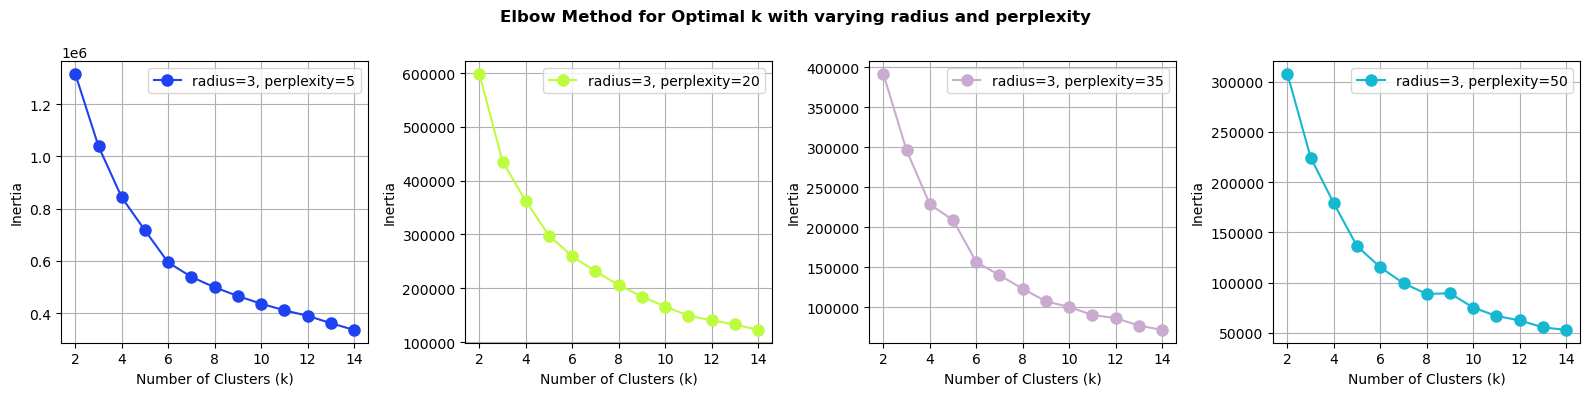

In [ ]:
# We don't need radius here as we do not use Morgan Fingerprints, but for the implementation it is necessary to still pass the parameter
radiuses = [3]
perplexities = [5,20,35,50]
Ks = range(2, 15)
nrows, ncols = len(radiuses), len(perplexities)

tsne_results, KLs, s_scores = plot_elbow_curve(
                                                method='tsne',
                                                original_data=embeddings,
                                                param1_list=radiuses,
                                                param2_list=perplexities,
                                                Ks=Ks,
                                                param1_name='radius',
                                                param2_name='perplexity',
                                                metric='cosine'
                                                        )

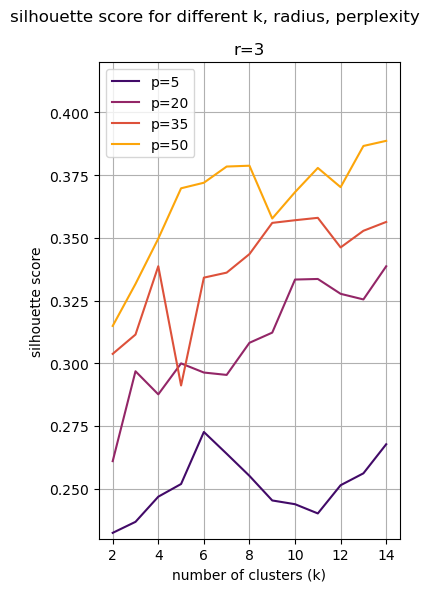

In [ ]:
plot_silhouette_scores(
    s_scores, Ks, radiuses, perplexities, 
    param1_name='r', param2_name='p', y_lim=(0.23, 0.42),
    color_palette="inferno", title="silhouette score for different k, radius, perplexity"
)

In [ ]:
# Choose best k for each perplexity based on the graphes (not always clearly defined for some) (above 12 is excessive)
best_ks = [[6,10,11,8]]

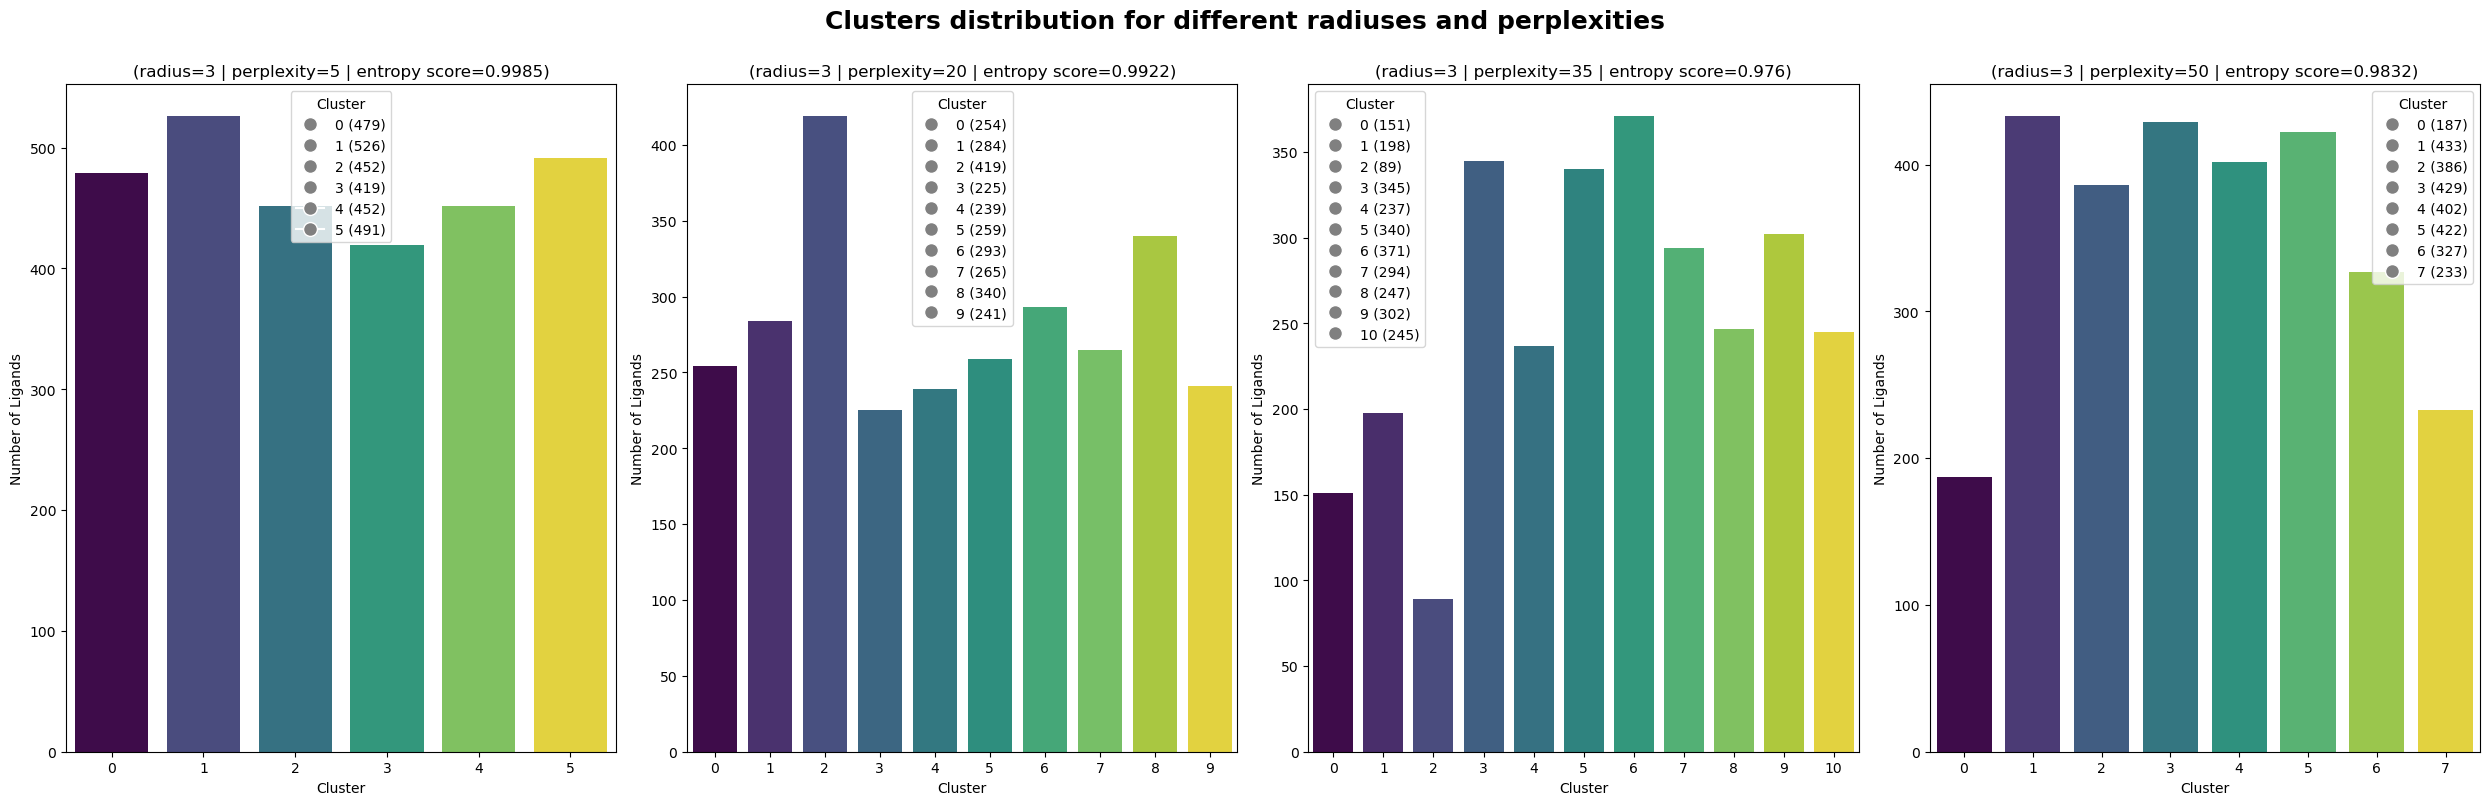

In [ ]:
plot_cluster_distributions(
    results=tsn_results, best_ks=best_ks, param1_values=radiuses, param2_values=perplexities,
    param1_name='radius', param2_name='perplexity',
    title="Clusters distribution for different radiuses and perplexities",
    figsize=(25,8)
)

In [ ]:
best_p = 0
best_kl = 100.0
for idx_r in range(nrows):
    for idx_p in range(ncols):
        print(f'perplexity: {perplexities[idx_p]} | KL score: {KLs[idx_r][idx_p]}')
        if KLs[idx_r][idx_p] < best_kl:
            min_index = (idx_r,idx_p)
            best_kl = KLs[idx_r][idx_p]
            best_p = perplexities[idx_p]

perplexity: 5 | KL score: 0.499663382768631
perplexity: 20 | KL score: 0.5889309048652649
perplexity: 35 | KL score: 0.613968014717102
perplexity: 50 | KL score: 0.6162129640579224


In [ ]:
# use KL or choose manually 

MANUAL_INDEX = True

if MANUAL_INDEX:
    min_index = (0,3)
    best_kl = KLs[idx_r][idx_p]
    best_p = perplexities[idx_p]

print(min_index)

(0, 3)


In [ ]:
print(f'Our best hyperparameters is: Perplexity of {best_p} with KL Divergence of {best_kl}')

Our best hyperparameters is: Perplexity of 50 with KL Divergence of 0.6162129640579224


In [ ]:
TSNE_BERT_df = plot_3d_clusters(tsn_results, min_index, k, method_name='TSNE')

In the case the 3D interactive plot does not render (if you are not using VSCode), below is a saved image of the plot:

![3D plot of BERT embedding clustering using t-SNE dimension reduction](test/TSNE_BERT.png)

#### Using UMAP to reduce dimensions ####

N_neighbors = 15
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 25
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 50
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 100
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6


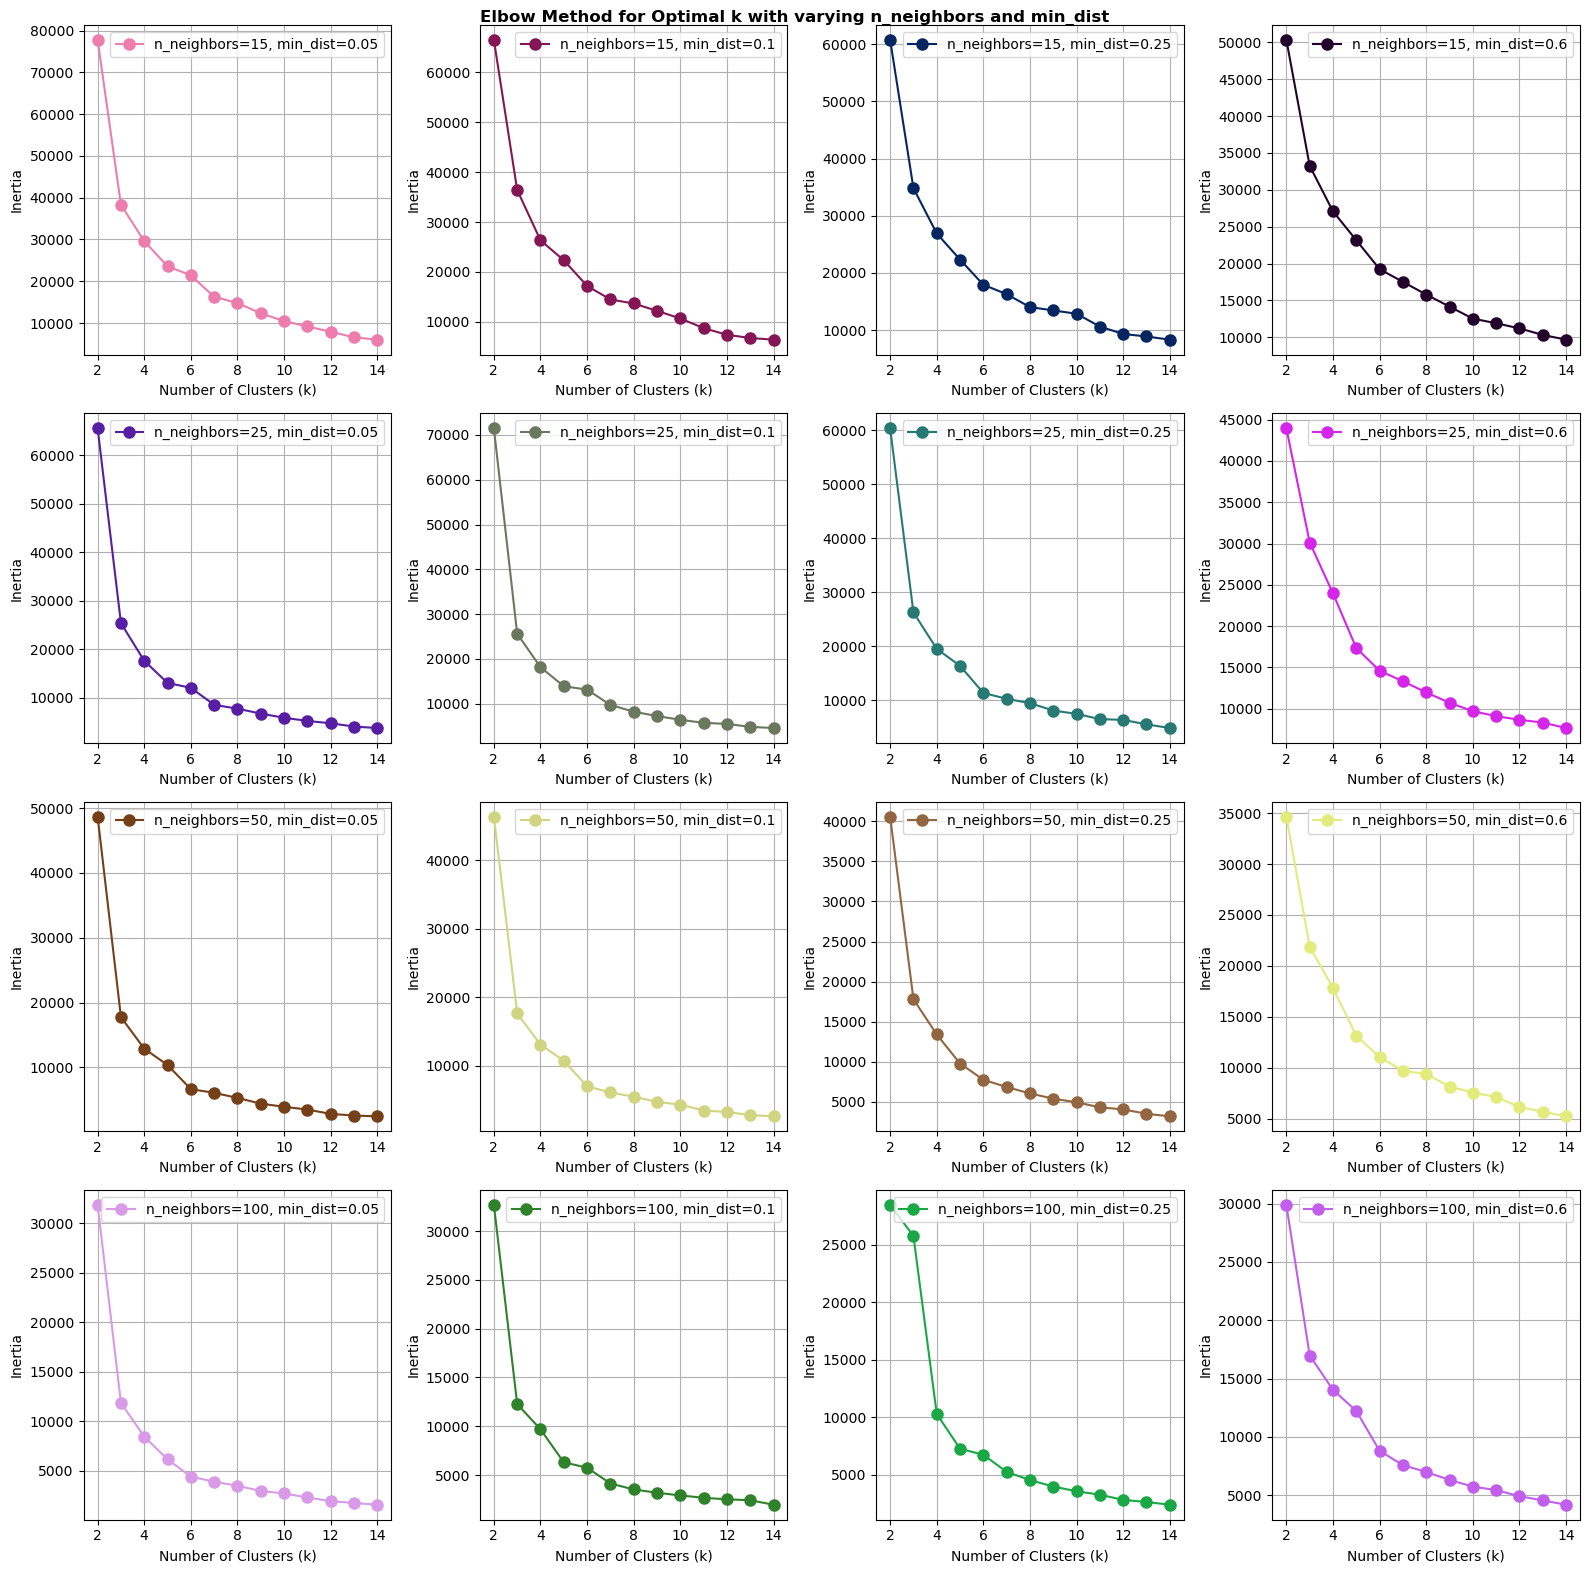

In [ ]:
l_n_neighbors = [15,25,50,100]
min_dists = [0.05,0.1,0.25,0.6]
nrows, ncols = len(l_n_neighbors), len(min_dists)
Ks = range(2, 15)

umap_results, trust_scores, s_scores = plot_elbow_curve(
                                        method='umap',
                                        original_data=embeddings,
                                        param1_list=l_n_neighbors,
                                        param2_list=min_dists,
                                        Ks=Ks,
                                        param1_name='n_neighbors',
                                        param2_name='min_dist',
                                        metric='cosine')

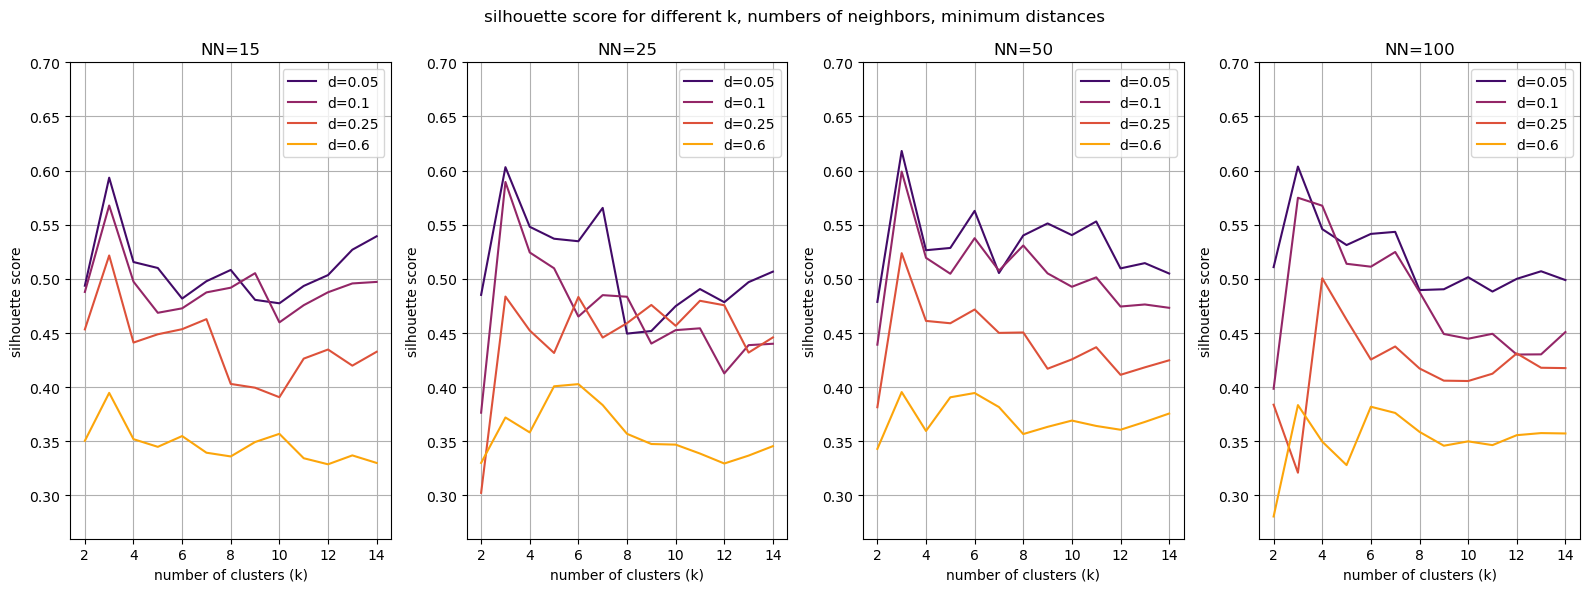

In [ ]:
plot_silhouette_scores(
    s_scores, Ks, l_n_neighbors, min_dists, 
    param1_name='NN', param2_name='d', y_lim=(0.26, 0.7),
    color_palette="inferno", title="silhouette score for different k, numbers of neighbors, minimum distances"
)

In [ ]:
# Choose best k for each number of neighbors and minimum distance based on the graphes (not always clearly defined for some) (above 12 is excessive)
best_ks = [[3,3,3,3],
           [3,3,3,6],
           [3,3,3,3],
           [3,3,4,3]]

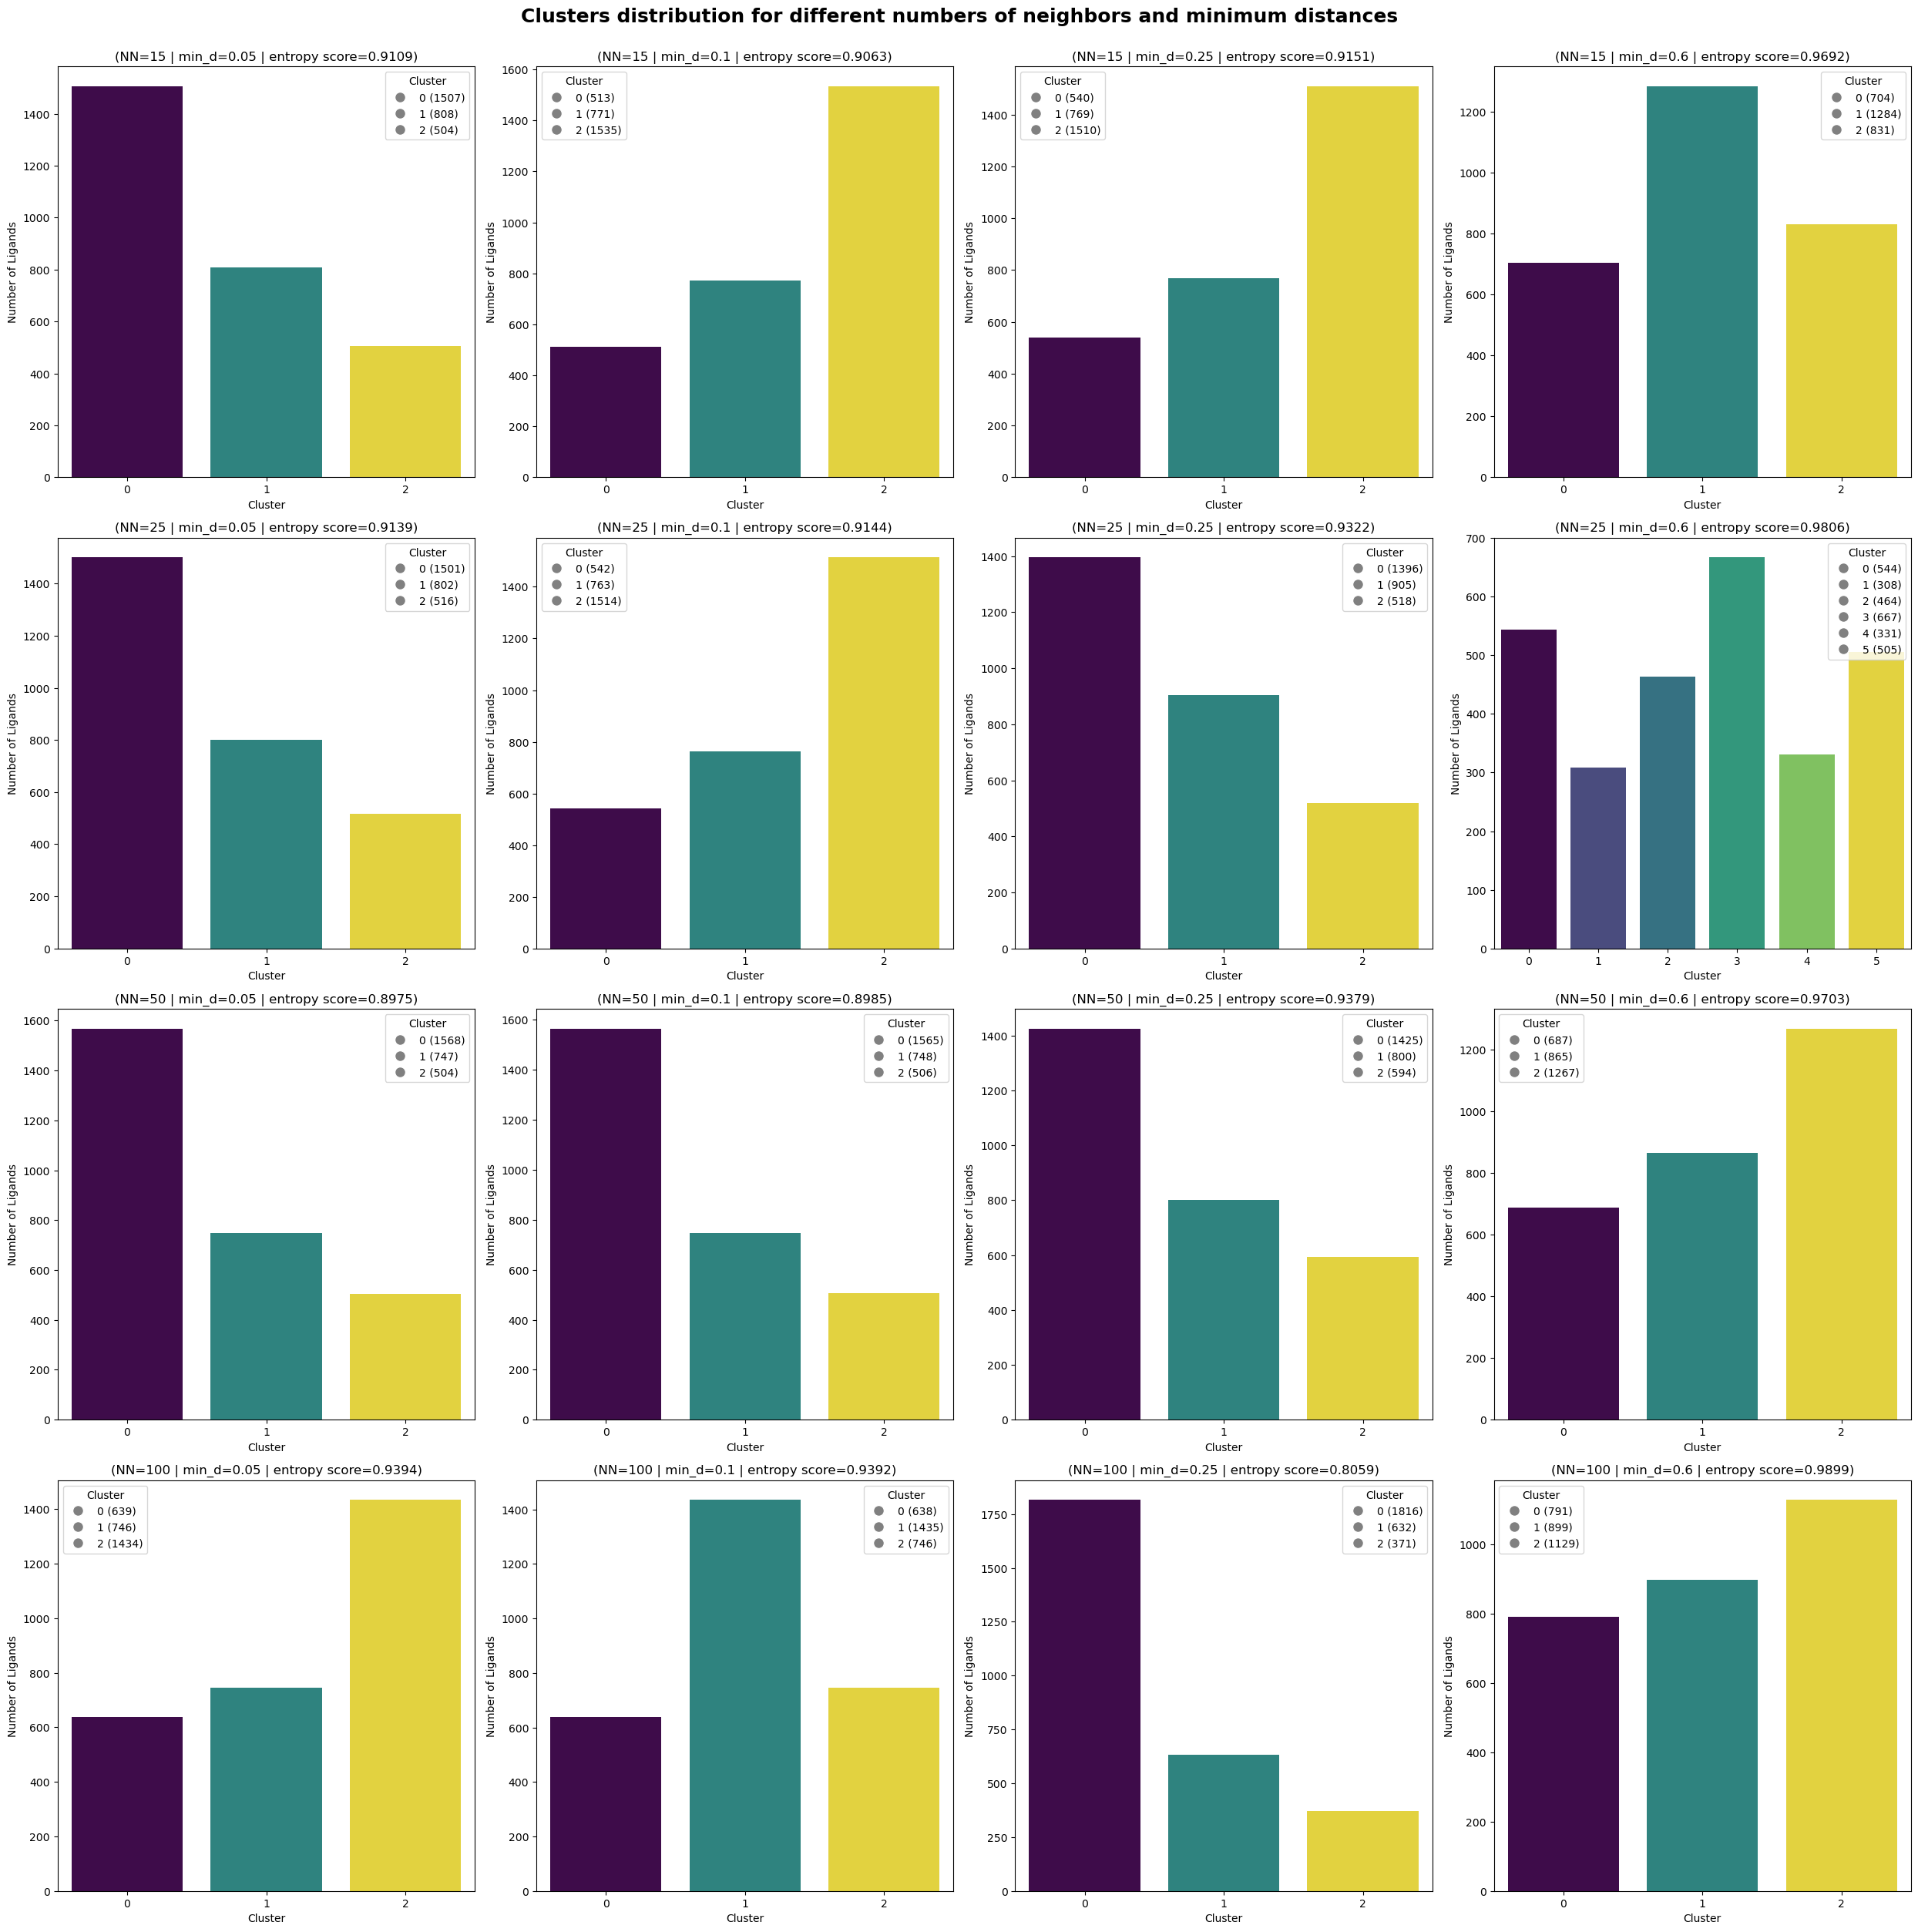

In [ ]:
plot_cluster_distributions(
    results=umap_results, best_ks=best_ks, param1_values=l_n_neighbors, param2_values=min_dists,
    param1_name='NN', param2_name='min_d', figsize=(25,25),
    title="Clusters distribution for different numbers of neighbors and minimum distances"
)

In [ ]:
best_NN = 0
best_d = 0
best_trust = 0
for idx_n in range(nrows):
    for idx_d in range(ncols):
        print(f'number of neighbors: {l_n_neighbors[idx_n]} | minimum distance: {min_dists[idx_d]} | trust score: {trust_scores[idx_n][idx_d]}')
        if trust_scores[idx_n][idx_d] > best_trust:
            min_index = (idx_n,idx_d)
            best_kl = trust_scores[idx_n][idx_d]
            best_NN = l_n_neighbors[idx_n]
            best_d = min_dists[idx_d]

number of neighbors: 15 | minimum distance: 0.05 | trust score: 0.9829623832962612
number of neighbors: 15 | minimum distance: 0.1 | trust score: 0.9824625730130528
number of neighbors: 15 | minimum distance: 0.25 | trust score: 0.9848113819248532
number of neighbors: 15 | minimum distance: 0.6 | trust score: 0.9831522692513486
number of neighbors: 25 | minimum distance: 0.05 | trust score: 0.9763508753400507
number of neighbors: 25 | minimum distance: 0.1 | trust score: 0.9755066834072335
number of neighbors: 25 | minimum distance: 0.25 | trust score: 0.9758585924683522
number of neighbors: 25 | minimum distance: 0.6 | trust score: 0.9726525366793037
number of neighbors: 50 | minimum distance: 0.05 | trust score: 0.9561405736141919
number of neighbors: 50 | minimum distance: 0.1 | trust score: 0.9569695445127387
number of neighbors: 50 | minimum distance: 0.25 | trust score: 0.9590068330750234
number of neighbors: 50 | minimum distance: 0.6 | trust score: 0.9569041572867288
number of 

In [ ]:
# use trustworthiness or choose manually 
MANUAL_INDEX = True

if MANUAL_INDEX:
    min_index = (2,0)
    best_NN = l_n_neighbors[min_index[0]]
    best_d = min_dists[min_index[1]]
    best_trust = trust_scores[min_index[0]][min_index[1]]
    
k = best_ks[min_index[0]][min_index[1]]

In [ ]:
print(f'Our best hyperparameters is: Number of Neighbors of {best_NN}, Minimum Distance of {best_d} with Trust Score of {best_trust}')

Our best hyperparameters is: Number of Neighbors of 50, Minimum Distance of 0.05 with Trust Score of 0.9561405736141919


In [ ]:
UMAP_BERT_df = plot_3d_clusters(umap_results, (2,0), k, method_name='UMAP')

In the case the 3D interactive plot does not render (if you are not using VSCode), below is a saved image of the plot:

![3D plot of BERT embedding clustering using UMAP dimension reduction](test/UMAP_BERT.png)

# Clusters Analysis
According to the silhouette score and the visual map, we chose to keep the clustering with Morgan fingerprint clustering and dimension reduction by UMAP.

In [3]:
#import hiv_data_clusters dataset
file_path = 'src/hiv_data_uniqueSMILES_clusters.csv'
hiv_data = pd.read_csv(file_path, sep=',')

hiv_data.shape

(4171, 27)

In [4]:
extract_info_smiles(hiv_data)

We would like to look at the targets in HIV each clusters have 

/Users/leonardotredici/Desktop/ada-project/ada-2024-project-trendtrackers/src/implementations.py:458: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Compound Count', y='Target Name', data=target_counts.head(20), palette='viridis', ax = ax)
/Users/leonardotredici/Desktop/ada-project/ada-2024-project-trendtrackers/src/implementations.py:458: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Compound Count', y='Target Name', data=target_counts.head(20), palette='viridis', ax = ax)
/Users/leonardotredici/Desktop/ada-project/ada-2024-project-trendtrackers/src/implementations.py:458: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign 

Text(0.5, 0.98, 'Top 20 Targets by Number of Compounds')

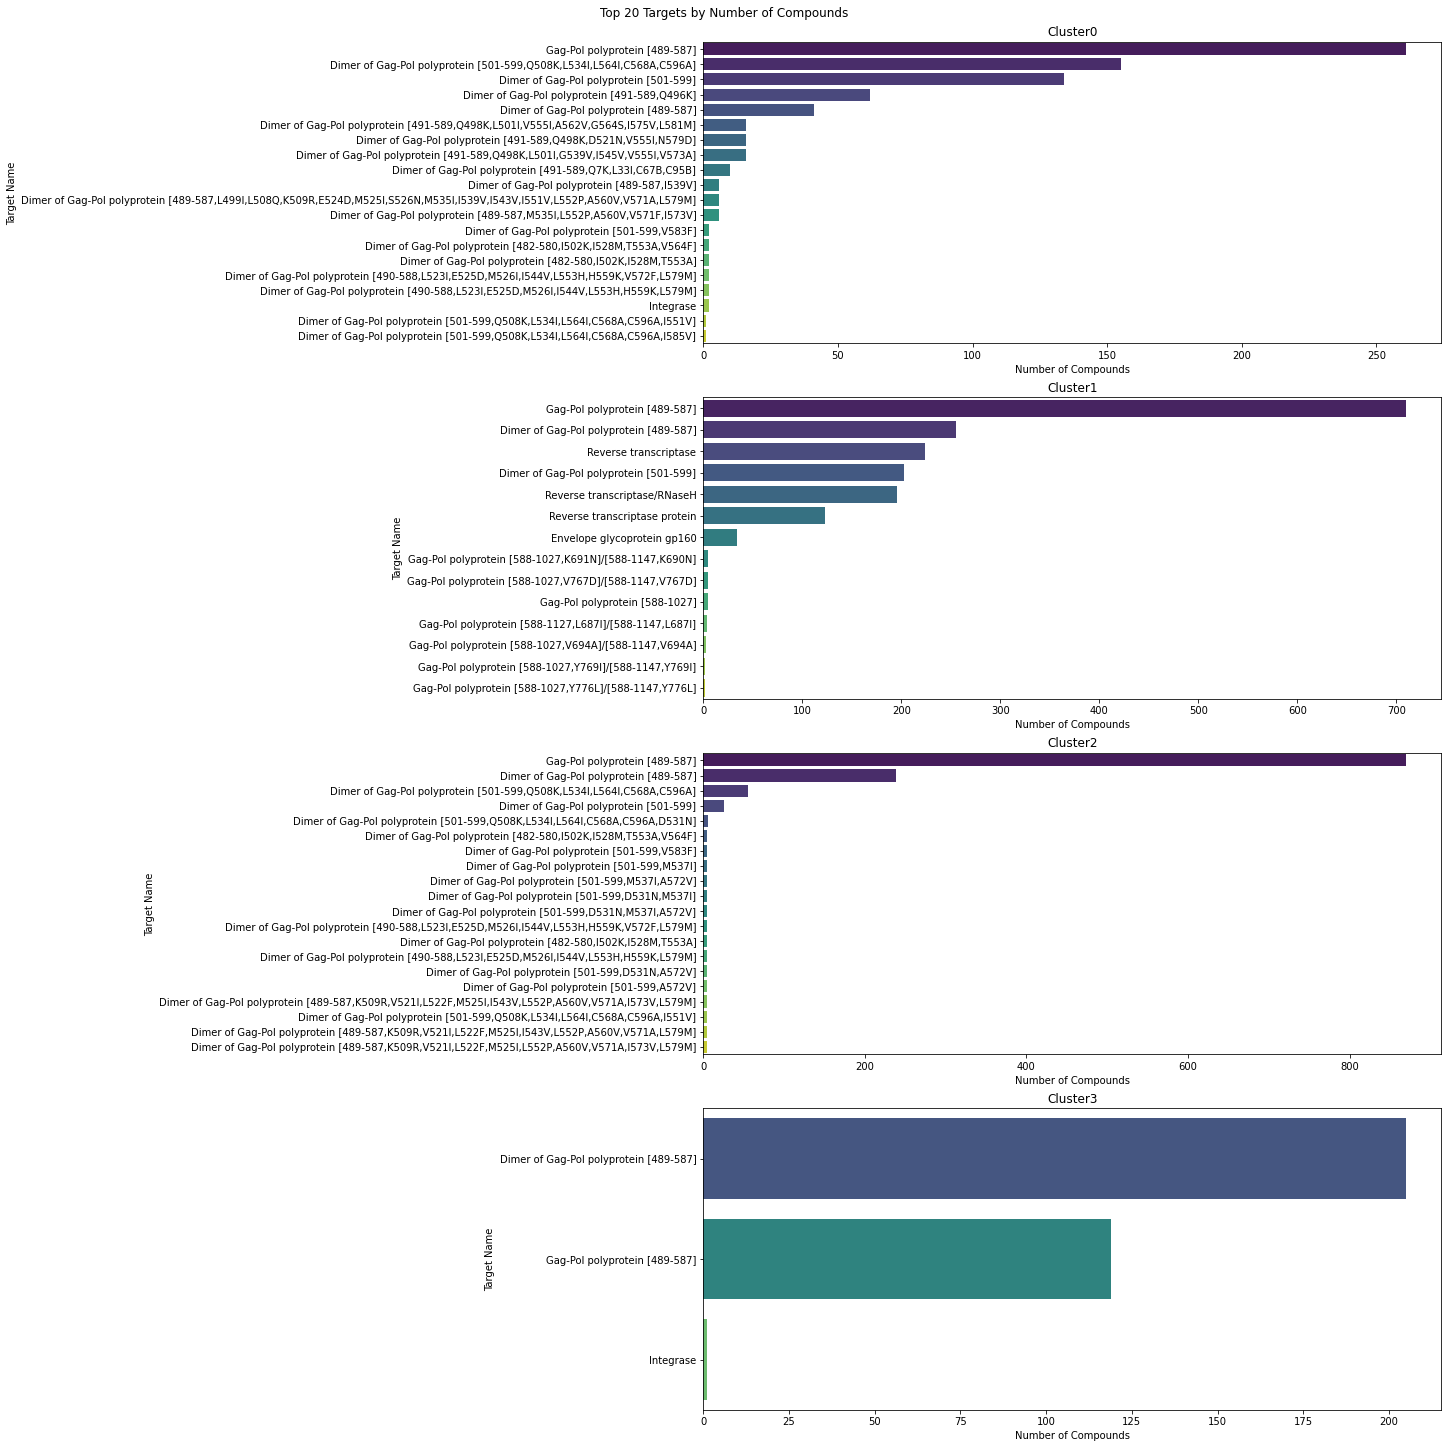

In [5]:
cluster_dataframes={}
for cluster in range(4):
    cluster_dataframes[f'Cluster_{cluster}'] = hiv_data[hiv_data['Cluster'] == cluster]

data_list = [
    {"data": cluster_dataframes['Cluster_0'], "title": "Cluster0", "xlim": (0, 750)},
    {"data": cluster_dataframes['Cluster_1'], "title": "Cluster1", "xlim": (0, 1500)},
    {"data": cluster_dataframes['Cluster_2'], "title": "Cluster2", "xlim": (0, 1500)},
    {"data": cluster_dataframes['Cluster_3'], "title": "Cluster3", "xlim": (0, 1500)}
]

fig, axes = plt.subplots(4, 1, figsize=(20, 20), constrained_layout=True)
# Loop through the data and axes
for ax, data_dict in zip(axes, data_list):
    clusters_targets(data_dict["data"], ax=ax, title = data_dict["title"])

plt.suptitle("Top 20 Targets by Number of Compounds")

The mostly targeted protein in HIV is Gag-pol polyprotein [489-587]. Therefore, we will focus that target.

# Absorption, Distribution, Metabolism, Excretion, and Toxicity (ADMET) properties

In [7]:
from admet_ai import ADMETModel
model = ADMETModel()
preds = model.predict(smiles=hiv_data['Ligand SMILES'])

df = pd.DataFrame(preds)


ModuleNotFoundError: No module named 'admet_ai'

In [6]:
df.to_csv('src/ADMET.csv', index=False)
print("Dataset with clusters saved as 'ADMET.csv'.")

NameError: name 'df' is not defined

In [7]:
data_ADMET= pd.read_csv('src/ADMET.csv')
data_ADMET['Cluster']=hiv_data['Cluster'].copy()


In [8]:
gagpol_df= hiv_data[hiv_data['Target Name']== 'Gag-Pol polyprotein [489-587]']
gagpol_cluster_df={}
for cluster in range(4):
    gagpol_cluster_df[f'Cluster_{cluster}'] = gagpol_df[gagpol_df['Cluster'] == cluster].reset_index(drop=True)
   

data_ADMET['Target Name'] = hiv_data['Target Name']
data_ADMET['Ki']= hiv_data['Ki (nM)']
gagpol_ADMET = data_ADMET[data_ADMET['Target Name']== 'Gag-Pol polyprotein [489-587]']

ADMET_clusters_dataframes_gagpol={}
for cluster in range(4):
    ADMET_clusters_dataframes_gagpol[f'Cluster_{cluster}'] = gagpol_ADMET[gagpol_ADMET['Cluster'] == cluster].reset_index(drop=True)

### Ki (nM)

In [9]:
gagpol_grouped = gagpol_df.groupby('Cluster')
gagpol_grouped['Ki (nM)'].describe()

count          mean           std       min    25%       50%    75%  \
Cluster                                                                        
0        261.0   4320.234440  3.093881e+04  0.000006  1.000  12.00000  125.0   
1        710.0  17342.100802  4.139565e+05  0.010000  0.063   0.40869   14.0   
2        870.0  87196.601191  2.042362e+06  0.010000  3.000  20.00000  355.0   
3        119.0    100.867874  2.466161e+02  0.007000  0.765   9.00000   46.5   

                max  
Cluster              
0          337300.0  
1        11000000.0  
2        60000000.0  
3            1500.0

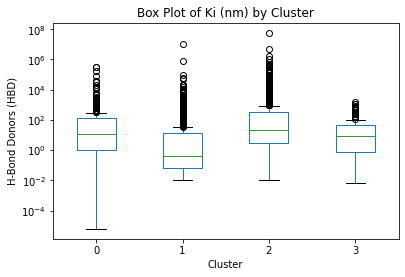

In [10]:
gagpol_df.boxplot(column='Ki (nM)', by='Cluster', grid=False)
plt.title('Box Plot of Ki (nm) by Cluster')
plt.suptitle('')
plt.yscale('log')
plt.xlabel('Cluster')
plt.ylabel('H-Bond Donors (HBD)')
plt.show()

In [11]:
shapiro_test(gagpol_cluster_df, 'Ki (nM)')

Shapiro-Wilk test for the parameter: Ki (nM)
Statistic: 0.12153222332178548, p-value: 5.1596642430916976e-33
Data does not look normally distributed (reject H0).
Statistic: 0.018847139704102678, p-value: 1.0337734098154459e-50
Data does not look normally distributed (reject H0).
Statistic: 0.018828401704667153, p-value: 1.3806398742992205e-54
Data does not look normally distributed (reject H0).
Statistic: 0.4625086668550662, p-value: 5.694400713703416e-19
Data does not look normally distributed (reject H0).


The distribution of the Ki values is not normal in the clusters, so we can not use a t-test to test if there is a significant difference of Ki values between the cluster. We will use a Kruskal-Wallis test.

In [12]:
test_kruskal('Ki (nM)', gagpol_grouped)

Kruskal-Wallis test for Ki (nM).
H-statistic: 288.1500258762292, p-value: 3.6497717659766916e-62.
There is a significant difference in the medians of at least one group compared to the other in Ki (nM).



In [13]:
mann_whiteney_test(gagpol_cluster_df['Cluster_0']['Ki (nM)'], gagpol_cluster_df['Cluster_1']['Ki (nM)'], 'cluster 0 and cluster 1.')
mann_whiteney_test(gagpol_cluster_df['Cluster_0']['Ki (nM)'], gagpol_cluster_df['Cluster_2']['Ki (nM)'], 'cluster 0 and cluster 2.')
mann_whiteney_test(gagpol_cluster_df['Cluster_0']['Ki (nM)'], gagpol_cluster_df['Cluster_3']['Ki (nM)'], 'cluster 0 and cluster 3.')
mann_whiteney_test(gagpol_cluster_df['Cluster_1']['Ki (nM)'], gagpol_cluster_df['Cluster_2']['Ki (nM)'], 'cluster 1 and cluster 2.')
mann_whiteney_test(gagpol_cluster_df['Cluster_1']['Ki (nM)'], gagpol_cluster_df['Cluster_3']['Ki (nM)'], 'cluster 1 and cluster 3.')
mann_whiteney_test(gagpol_cluster_df['Cluster_2']['Ki (nM)'], gagpol_cluster_df['Cluster_3']['Ki (nM)'], 'cluster 0 and cluster 1.')

Mann-Whiney U test
Statistic: 125852.0, p-value: 1.0479425780468135e-17
Significant difference between cluster 0 and cluster 1.
Mann-Whiney U test
Statistic: 97055.0, p-value: 0.0003698043608676678
Significant difference between cluster 0 and cluster 2.
Mann-Whiney U test
Statistic: 16733.5, p-value: 0.22551752349119214
No significant difference between cluster 0 and cluster 3.
Mann-Whiney U test
Statistic: 158781.0, p-value: 3.8700421074089723e-62
Significant difference between cluster 1 and cluster 2.
Mann-Whiney U test
Statistic: 28806.5, p-value: 2.714033329336853e-08
Significant difference between cluster 1 and cluster 3.
Mann-Whiney U test
Statistic: 63568.5, p-value: 5.3751309248657444e-05
Significant difference between cluster 0 and cluster 1.


There is a statically significant difference between each cluster pairwise, except between cluster 3 and 0.

The cluster 1 is the one with the lowest mean and he is stastically significantly different to each cluster.

### Molecular weight.

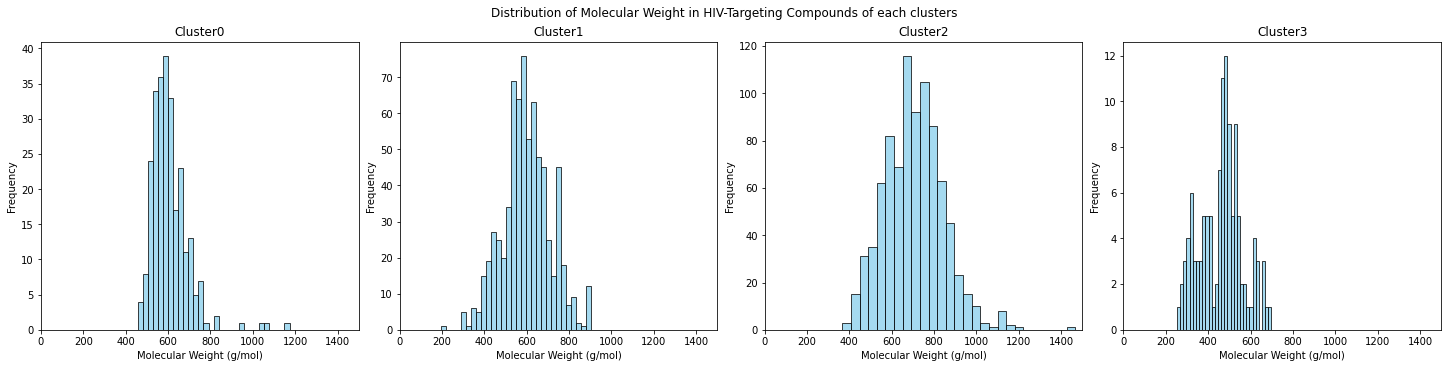

[606.1480383141763, 598.5711690140847, 706.6104724137931, 461.4767142857145]


In [14]:
data_list = [
    {"data": gagpol_cluster_df['Cluster_0'], "title": "Cluster0", "xlim": (0, 1500)},
    {"data": gagpol_cluster_df['Cluster_1'], "title": "Cluster1", "xlim": (0, 1500)},
    {"data": gagpol_cluster_df['Cluster_2'], "title": "Cluster2", "xlim": (0, 1500)},
    {"data": gagpol_cluster_df['Cluster_3'], "title": "Cluster3", "xlim": (0, 1500)}
]

molecular_weight_mean= []
fig, axes = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)
# Loop through the data and axes
for ax, data_dict in zip(axes, data_list):
    MW_histplot(data_dict["data"], ax=ax, title= data_dict["title"], xlim=data_dict["xlim"])
    molecular_weight_mean.append(data_dict['data']['Molecular Weight'].mean())

# Show the figure
fig.suptitle("Distribution of Molecular Weight in HIV-Targeting Compounds of each clusters")
plt.show()

print(molecular_weight_mean)

In [15]:
#Test wheter the distribution of the molecular weight is normal among the clusters
shapiro_test(gagpol_cluster_df, 'Molecular Weight')


Shapiro-Wilk test for the parameter: Molecular Weight
Statistic: 0.833382962700522, p-value: 4.667469979055624e-16
Data does not look normally distributed (reject H0).
Statistic: 0.9941546880295726, p-value: 0.007659234472644573
Data does not look normally distributed (reject H0).
Statistic: 0.9598564100052007, p-value: 1.0476790149637094e-14
Data does not look normally distributed (reject H0).
Statistic: 0.9780649904729165, p-value: 0.048749979602563984
Data does not look normally distributed (reject H0).


In [16]:

mann_whiteney_test(gagpol_cluster_df['Cluster_0']['Molecular Weight'], gagpol_cluster_df['Cluster_1']['Molecular Weight'], 'cluster 0 and cluster 1.')
mann_whiteney_test(gagpol_cluster_df['Cluster_0']['Molecular Weight'], gagpol_cluster_df['Cluster_2']['Molecular Weight'], 'cluster 0 and cluster 2.')
mann_whiteney_test(gagpol_cluster_df['Cluster_0']['Molecular Weight'], gagpol_cluster_df['Cluster_3']['Molecular Weight'], 'cluster 0 and cluster 3.')
mann_whiteney_test(gagpol_cluster_df['Cluster_1']['Molecular Weight'], gagpol_cluster_df['Cluster_2']['Molecular Weight'], 'cluster 1 and cluster 2.')
mann_whiteney_test(gagpol_cluster_df['Cluster_1']['Molecular Weight'], gagpol_cluster_df['Cluster_3']['Molecular Weight'], 'cluster 1 and cluster 3.')
mann_whiteney_test(gagpol_cluster_df['Cluster_2']['Molecular Weight'], gagpol_cluster_df['Cluster_3']['Molecular Weight'], 'cluster 0 and cluster 1.')

Mann-Whiney U test
Statistic: 93326.0, p-value: 0.8626002045840185
No significant difference between cluster 0 and cluster 1.
Mann-Whiney U test
Statistic: 59176.5, p-value: 7.491368151104245e-32
Significant difference between cluster 0 and cluster 2.
Mann-Whiney U test
Statistic: 27271.0, p-value: 2.9519904125545254e-32
Significant difference between cluster 0 and cluster 3.
Mann-Whiney U test
Statistic: 171120.0, p-value: 1.2615766033683356e-52
Significant difference between cluster 1 and cluster 2.
Mann-Whiney U test
Statistic: 69315.0, p-value: 4.179139301807379e-29
Significant difference between cluster 1 and cluster 3.
Mann-Whiney U test
Statistic: 95670.0, p-value: 5.2023084638425696e-51
Significant difference between cluster 0 and cluster 1.


The molecular weight of the clusters are statistically different among clusters except between cluster 0 and 1.

### H bonds

In [17]:
hbond_stats = gagpol_grouped[['H-Bond Donors', 'H-Bond Acceptors']].describe()
print(hbond_stats)

        H-Bond Donors                                                \
                count      mean       std  min  25%  50%  75%   max   
Cluster                                                               
0               261.0  3.425287  1.771346  1.0  2.0  3.0  4.0  11.0   
1               710.0  3.261972  1.363060  0.0  2.0  3.0  4.0   7.0   
2               870.0  5.656322  2.028066  1.0  4.0  6.0  7.0  18.0   
3               119.0  1.411765  0.896431  0.0  1.0  1.0  2.0   4.0   

        H-Bond Acceptors                                                
                   count      mean       std  min  25%  50%  75%   max  
Cluster                                                                 
0                  261.0  7.302682  1.572710  4.0  6.0  7.0  8.0  17.0  
1                  710.0  5.200000  1.922915  1.0  4.0  5.0  7.0  12.0  
2                  870.0  8.078161  2.226187  1.0  7.0  8.0  9.0  18.0  
3                  119.0  5.100840  1.791671  2.0  3.0  6.0  6.0

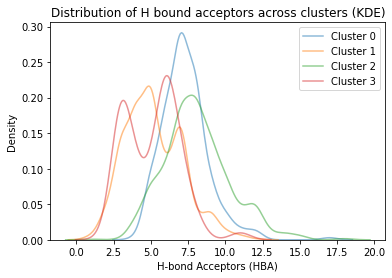

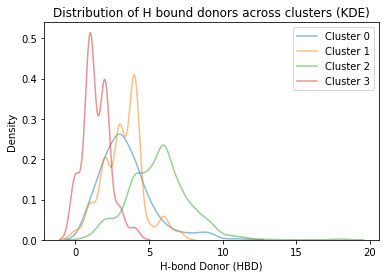

In [18]:
for cluster, cluster_data in gagpol_grouped:
    sns.kdeplot(cluster_data['H-Bond Acceptors'], label=f'Cluster {cluster}', fill=False, alpha=0.5)

plt.xlabel('H-bond Acceptors (HBA)')
plt.ylabel('Density')
plt.title('Distribution of H bound acceptors across clusters (KDE)')
plt.legend()
plt.show()

for cluster, cluster_data in gagpol_grouped:
    sns.kdeplot(cluster_data['H-Bond Donors'], label=f'Cluster {cluster}', fill=False, alpha=0.5)

plt.xlabel('H-bond Donor (HBD)')
plt.ylabel('Density')
plt.title('Distribution of H bound donors across clusters (KDE)')
plt.legend()
plt.show()

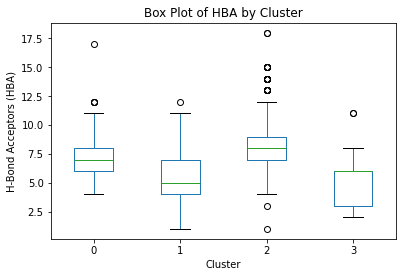

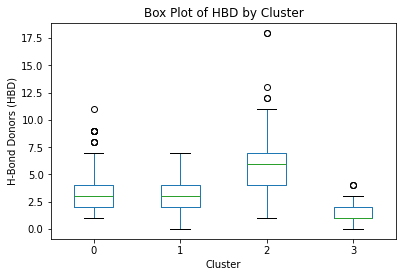

In [19]:
gagpol_df.boxplot(column='H-Bond Acceptors', by='Cluster', grid=False)
plt.title('Box Plot of HBA by Cluster')
plt.suptitle('')
plt.xlabel('Cluster')
plt.ylabel('H-Bond Acceptors (HBA)')
plt.show()

gagpol_df.boxplot(column='H-Bond Donors', by='Cluster', grid=False)
plt.title('Box Plot of HBD by Cluster')
plt.suptitle('')
plt.xlabel('Cluster')
plt.ylabel('H-Bond Donors (HBD)')
plt.show()

In [20]:
shapiro_test(gagpol_cluster_df, 'H-Bond Acceptors')

Shapiro-Wilk test for the parameter: H-Bond Acceptors
Statistic: 0.8896181173309405, p-value: 7.456923806860111e-13
Data does not look normally distributed (reject H0).
Statistic: 0.9516473956163252, p-value: 1.692524025982661e-14
Data does not look normally distributed (reject H0).
Statistic: 0.9582803991220911, p-value: 4.992253565794199e-15
Data does not look normally distributed (reject H0).
Statistic: 0.8830525328826431, p-value: 3.239485629885485e-08
Data does not look normally distributed (reject H0).


In [21]:
shapiro_test(gagpol_cluster_df, 'H-Bond Donors')

Shapiro-Wilk test for the parameter: H-Bond Donors
Statistic: 0.8839022247755615, p-value: 3.169156754620818e-13
Data does not look normally distributed (reject H0).
Statistic: 0.9257041825050903, p-value: 3.03442440453038e-18
Data does not look normally distributed (reject H0).
Statistic: 0.9474818497830767, p-value: 4.939505794903106e-17
Data does not look normally distributed (reject H0).
Statistic: 0.8725922673829126, p-value: 1.0911182866705689e-08
Data does not look normally distributed (reject H0).


The assumptions of ANOVA are not met, so we cannot perform an ANOVA test. So instead we will do a Kruskal-Wallis test to analyse the differences between clusters.

In [22]:
# Perform a Kruskal-Wallis test to test if there is a statistically significant difference between the medians of each cluster
test_kruskal('H-Bond Acceptors', gagpol_grouped)
test_kruskal('H-Bond Donors', gagpol_grouped)

Kruskal-Wallis test for H-Bond Acceptors.
H-statistic: 665.7105609544376, p-value: 5.715077379936905e-144.
There is a significant difference in the medians of at least one group compared to the other in H-Bond Acceptors.

Kruskal-Wallis test for H-Bond Donors.
H-statistic: 812.4927345282644, p-value: 8.449436495634585e-176.
There is a significant difference in the medians of at least one group compared to the other in H-Bond Donors.



Next, we want to check between each cluster if there is a difference. We already know that the assumptions of the t-test are not verified (Shapiro test), so we will perform a Mann-Whitney U test instead.

In [23]:
print('Test for H bond acceptors: \n')
mann_whiteney_test(gagpol_cluster_df['Cluster_0']['H-Bond Acceptors'], gagpol_cluster_df['Cluster_1']['H-Bond Acceptors'], 'cluster 0 and cluster 1.')
mann_whiteney_test(gagpol_cluster_df['Cluster_0']['H-Bond Acceptors'], gagpol_cluster_df['Cluster_2']['H-Bond Acceptors'], 'cluster 0 and cluster 2.')
mann_whiteney_test(gagpol_cluster_df['Cluster_0']['H-Bond Acceptors'], gagpol_cluster_df['Cluster_3']['H-Bond Acceptors'], 'cluster 0 and cluster 3.')
mann_whiteney_test(gagpol_cluster_df['Cluster_1']['H-Bond Acceptors'], gagpol_cluster_df['Cluster_2']['H-Bond Acceptors'], 'cluster 1 and cluster 2.')
mann_whiteney_test(gagpol_cluster_df['Cluster_1']['H-Bond Acceptors'], gagpol_cluster_df['Cluster_3']['H-Bond Acceptors'], 'cluster 1 and cluster 3.')
mann_whiteney_test(gagpol_cluster_df['Cluster_2']['H-Bond Acceptors'], gagpol_cluster_df['Cluster_3']['H-Bond Acceptors'], 'cluster 0 and cluster 1.')

Test for H bond acceptors: 

Mann-Whiney U test
Statistic: 149110.0, p-value: 2.838565980967809e-49
Significant difference between cluster 0 and cluster 1.
Mann-Whiney U test
Statistic: 88085.5, p-value: 2.4638599302482048e-08
Significant difference between cluster 0 and cluster 2.
Mann-Whiney U test
Statistic: 25641.5, p-value: 3.3212471420060395e-25
Significant difference between cluster 0 and cluster 3.
Mann-Whiney U test
Statistic: 99703.0, p-value: 7.114042348180388e-121
Significant difference between cluster 1 and cluster 2.
Mann-Whiney U test
Statistic: 43196.5, p-value: 0.6898885104206662
No significant difference between cluster 1 and cluster 3.
Mann-Whiney U test
Statistic: 88787.5, p-value: 1.741409517530154e-37
Significant difference between cluster 0 and cluster 1.


In [24]:
print('Test for H bond donors: \n')
mann_whiteney_test(gagpol_cluster_df['Cluster_0']['H-Bond Donors'], gagpol_cluster_df['Cluster_1']['H-Bond Donors'], 'cluster 0 and cluster 1.')
mann_whiteney_test(gagpol_cluster_df['Cluster_0']['H-Bond Donors'], gagpol_cluster_df['Cluster_2']['H-Bond Donors'], 'cluster 0 and cluster 2.')
mann_whiteney_test(gagpol_cluster_df['Cluster_0']['H-Bond Donors'], gagpol_cluster_df['Cluster_3']['H-Bond Donors'], 'cluster 0 and cluster 3.')
mann_whiteney_test(gagpol_cluster_df['Cluster_1']['H-Bond Donors'], gagpol_cluster_df['Cluster_2']['H-Bond Donors'], 'cluster 1 and cluster 2.')
mann_whiteney_test(gagpol_cluster_df['Cluster_1']['H-Bond Donors'], gagpol_cluster_df['Cluster_3']['H-Bond Donors'], 'cluster 1 and cluster 3.')
mann_whiteney_test(gagpol_cluster_df['Cluster_2']['H-Bond Donors'], gagpol_cluster_df['Cluster_3']['H-Bond Donors'], 'cluster 0 and cluster 1.')

Test for H bond donors: 

Mann-Whiney U test
Statistic: 91742.0, p-value: 0.8080605084944132
No significant difference between cluster 0 and cluster 1.
Mann-Whiney U test
Statistic: 42631.0, p-value: 4.041676189102755e-54
Significant difference between cluster 0 and cluster 2.
Mann-Whiney U test
Statistic: 26746.0, p-value: 1.0677994169508946e-30
Significant difference between cluster 0 and cluster 3.
Mann-Whiney U test
Statistic: 98783.5, p-value: 1.981198595864292e-123
Significant difference between cluster 1 and cluster 2.
Mann-Whiney U test
Statistic: 73015.5, p-value: 3.5739050216389997e-39
Significant difference between cluster 1 and cluster 3.
Mann-Whiney U test
Statistic: 100847.5, p-value: 1.123690161010609e-64
Significant difference between cluster 0 and cluster 1.



For the H bond acceptor, we can see that for all pairwise comparisons, the p values are lower than 0.05, except between the cluster 1 and the cluster 3, so we reject the null hypothesis for all the other pairwise comparisons. The distributions of H bond acceptors differ significantly between those pairs of cluster.

For the H bond donors, we can see that for all pairwise comparisons, the p values are lower than 0.05, except between the cluster 1 and the cluster 0, so we reject the null hypothesis for all the other pairwise comparisons. The distributions of H bond donors differ significantly between those pairs of cluster.


### TPSA

In [25]:
grouped_admet = gagpol_ADMET.groupby('Cluster')
tpsa_stats = grouped_admet['tpsa'].describe()
print(tpsa_stats)

         count        mean        std    min       25%      50%     75%  \
Cluster                                                                   
0        261.0  138.938812  44.562263  75.52  108.4100  131.190  154.98   
1        710.0  110.865718  35.708615  20.23   84.2400  114.075  140.00   
2        870.0  180.591678  59.406813  20.23  145.2075  170.780  207.66   
3        119.0   87.432101  33.860862  26.30   50.4400   89.620  113.33   

            max  
Cluster          
0        401.44  
1        186.07  
2        548.57  
3        209.07  


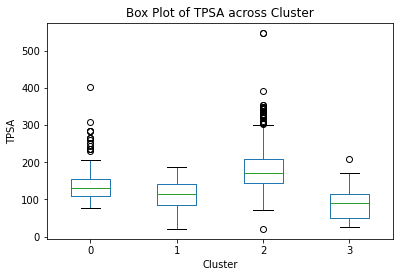

In [26]:
gagpol_ADMET.boxplot(column='tpsa', by='Cluster', grid=False)
plt.title('Box Plot of TPSA across Cluster')
plt.suptitle('')
plt.xlabel('Cluster')
plt.ylabel('TPSA')
plt.show()

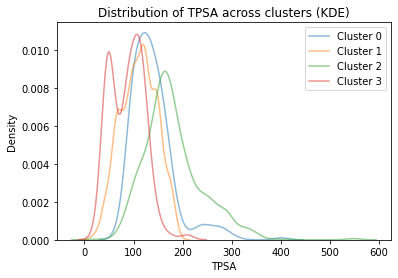

In [27]:
for cluster, cluster_data in grouped_admet:
    sns.kdeplot(cluster_data['tpsa'], label=f'Cluster {cluster}', fill=False, alpha=0.5)

plt.xlabel('TPSA')
plt.ylabel('Density')
plt.title('Distribution of TPSA across clusters (KDE)')
plt.legend()
plt.show()

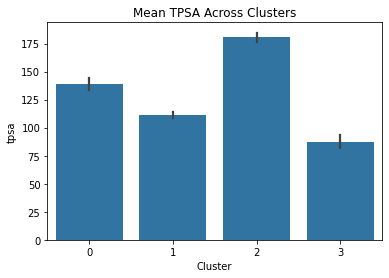

In [28]:
sns.barplot(x='Cluster', y='tpsa', data=gagpol_ADMET, estimator='mean')
plt.title('Mean TPSA Across Clusters')
plt.show()

In [29]:
# A faire: shapiro test tpsa
shapiro_test(ADMET_clusters_dataframes_gagpol, 'tpsa')

Shapiro-Wilk test for the parameter: tpsa
Statistic: 0.8351334987442532, p-value: 5.70399989175049e-16
Data does not look normally distributed (reject H0).
Statistic: 0.9805991104413027, p-value: 4.316103397839245e-08
Data does not look normally distributed (reject H0).
Statistic: 0.9348270845734191, p-value: 4.881468211580432e-19
Data does not look normally distributed (reject H0).
Statistic: 0.9317231384595794, p-value: 1.335113705632447e-05
Data does not look normally distributed (reject H0).


In [30]:
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_0']['tpsa'], ADMET_clusters_dataframes_gagpol['Cluster_1']['tpsa'], 'cluster 0 and cluster 1.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_0']['tpsa'], ADMET_clusters_dataframes_gagpol['Cluster_2']['tpsa'], 'cluster 0 and cluster 2.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_0']['tpsa'], ADMET_clusters_dataframes_gagpol['Cluster_3']['tpsa'], 'cluster 0 and cluster 3.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_1']['tpsa'], ADMET_clusters_dataframes_gagpol['Cluster_2']['tpsa'], 'cluster 1 and cluster 2.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_1']['tpsa'], ADMET_clusters_dataframes_gagpol['Cluster_3']['tpsa'], 'cluster 1 and cluster 3.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_2']['tpsa'], ADMET_clusters_dataframes_gagpol['Cluster_3']['tpsa'], 'cluster 0 and cluster 1.')

Mann-Whiney U test
Statistic: 124915.5, p-value: 8.184012832597635e-17
Significant difference between cluster 0 and cluster 1.
Mann-Whiney U test
Statistic: 57927.5, p-value: 2.9609914123412886e-33
Significant difference between cluster 0 and cluster 2.
Mann-Whiney U test
Statistic: 25984.0, p-value: 6.374494819197868e-26
Significant difference between cluster 0 and cluster 3.
Mann-Whiney U test
Statistic: 88447.5, p-value: 7.63383283099528e-132
Significant difference between cluster 1 and cluster 2.
Mann-Whiney U test
Statistic: 58259.5, p-value: 3.430530421422634e-11
Significant difference between cluster 1 and cluster 3.
Mann-Whiney U test
Statistic: 96848.0, p-value: 1.0895420344890828e-53
Significant difference between cluster 0 and cluster 1.


We see that the p value of the Mann Whitney U test for tpsa for pairwise comparison between the clusters is lower than 0.05 for each pair of cluster, so there is a significant difference in the tpsa between each cluster.

### Stereo_centers.

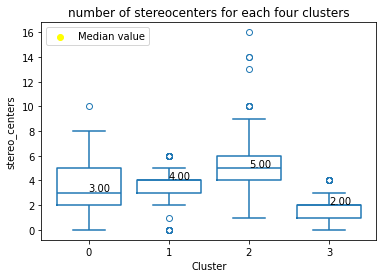

In [31]:
stereo(gagpol_ADMET)

In [32]:
shapiro_test(ADMET_clusters_dataframes_gagpol, 'stereo_centers')


Shapiro-Wilk test for the parameter: stereo_centers
Statistic: 0.9317942858839235, p-value: 1.3175836526533566e-09
Data does not look normally distributed (reject H0).
Statistic: 0.6803716946794658, p-value: 1.689977421737901e-34
Data does not look normally distributed (reject H0).
Statistic: 0.9531843428029824, p-value: 5.150507388354644e-16
Data does not look normally distributed (reject H0).
Statistic: 0.8485176299382416, p-value: 1.0853813203388238e-09
Data does not look normally distributed (reject H0).


In [33]:
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_0']['stereo_centers'], ADMET_clusters_dataframes_gagpol['Cluster_1']['stereo_centers'], 'cluster 0 and cluster 1.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_0']['stereo_centers'], ADMET_clusters_dataframes_gagpol['Cluster_2']['stereo_centers'], 'cluster 0 and cluster 2.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_0']['stereo_centers'], ADMET_clusters_dataframes_gagpol['Cluster_3']['stereo_centers'], 'cluster 0 and cluster 3.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_1']['stereo_centers'], ADMET_clusters_dataframes_gagpol['Cluster_2']['stereo_centers'], 'cluster 1 and cluster 2.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_1']['stereo_centers'], ADMET_clusters_dataframes_gagpol['Cluster_3']['stereo_centers'], 'cluster 1 and cluster 3.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_2']['stereo_centers'], ADMET_clusters_dataframes_gagpol['Cluster_3']['stereo_centers'], 'cluster 0 and cluster 1.')

Mann-Whiney U test
Statistic: 86109.5, p-value: 0.06622580858850448
No significant difference between cluster 0 and cluster 1.
Mann-Whiney U test
Statistic: 67031.0, p-value: 2.7156728931549387e-24
Significant difference between cluster 0 and cluster 2.
Mann-Whiney U test
Statistic: 25247.5, p-value: 2.1408016378399818e-23
Significant difference between cluster 0 and cluster 3.
Mann-Whiney U test
Statistic: 133760.5, p-value: 2.4158193647536618e-90
Significant difference between cluster 1 and cluster 2.
Mann-Whiney U test
Statistic: 76608.0, p-value: 4.548162156368286e-57
Significant difference between cluster 1 and cluster 3.
Mann-Whiney U test
Statistic: 97608.0, p-value: 1.096659638460092e-56
Significant difference between cluster 0 and cluster 1.


Look for a correlation with Ki

<Figure size 432x288 with 0 Axes>

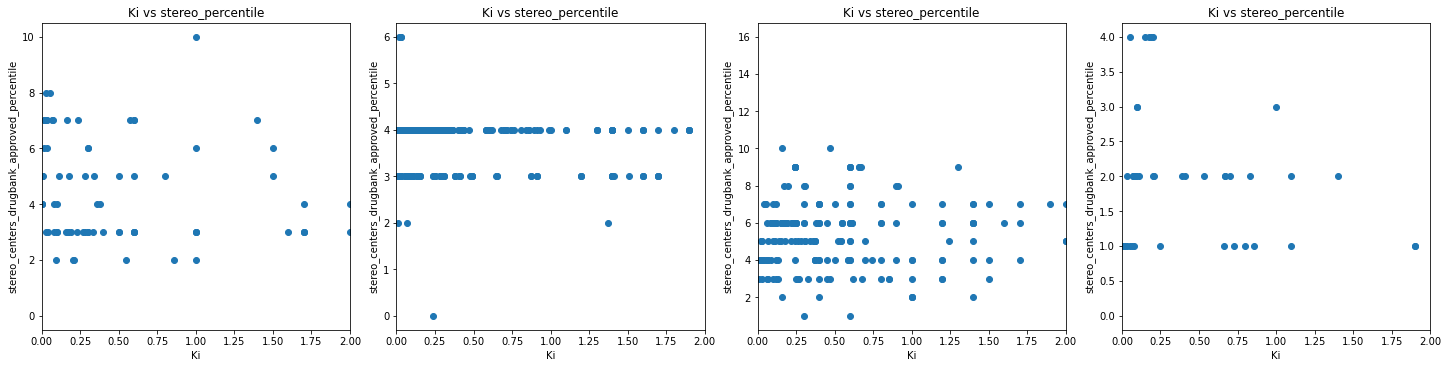

In [34]:
plt.figure()
fig, axes = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)
for ax, i in zip(axes, range(4)):
    ax.scatter(ADMET_clusters_dataframes_gagpol[f'Cluster_{i}']['Ki'],ADMET_clusters_dataframes_gagpol[f'Cluster_{i}']['stereo_centers'])
    ax.set_title('Ki vs stereo_percentile')
    ax.set_xlabel('Ki')
    ax.set_ylabel('stereo_centers_drugbank_approved_percentile')
    ax.set_xlim((0, 2))

plt.show()

Look for Hydrophobicity with LogP

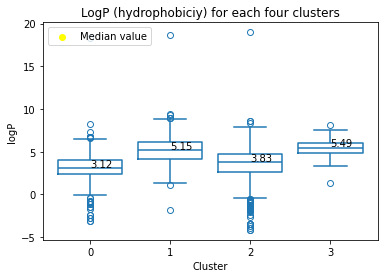

In [35]:
LogP(gagpol_ADMET)

In [36]:
shapiro_test(ADMET_clusters_dataframes_gagpol, 'logP')

Shapiro-Wilk test for the parameter: logP
Statistic: 0.8783026329284286, p-value: 1.4089321524797102e-13
Data does not look normally distributed (reject H0).
Statistic: 0.9482570431454462, p-value: 4.663584038324864e-15
Data does not look normally distributed (reject H0).
Statistic: 0.9243860209817586, p-value: 1.729591990431479e-20
Data does not look normally distributed (reject H0).
Statistic: 0.9778769163900249, p-value: 0.046847978804843676
Data does not look normally distributed (reject H0).


Since we went through the different properties of the ligands/drugs, we would like to focus on the cluster1 because of the smallest mean value of Ki among the clusters. The smaller the Ki, the greater the binding affinity and the smaller amount of medication needed in order to inhibit the activity of that enzyme. Therefore we would focus on that cluster in order to find the 10 most promising drugs targeting Gag-pol polyprotein.

In [37]:
weights_cluster1= weight(ADMET_clusters_dataframes_gagpol)
top_10_index= top10_compound(ADMET_clusters_dataframes_gagpol, weights_cluster1).index.tolist()
top10 = gagpol_cluster_df['Cluster_1'].iloc[top_10_index]

Indices of the top 10 most promising drugs: [8, 443, 541, 438, 331, 240, 621, 536, 251, 439]
Top 10 drugs data:
     Lipinski_Score            Ki  Solubility  Toxicity  Normalized_Ki  \
8               1.0  2.000000e-08    1.000000  0.621109       1.000000   
443             1.0  1.136355e-04    0.924693  0.499622       0.999886   
541             1.0  9.081818e-07    0.705632  0.942988       0.999999   
438             1.0  1.136355e-04    0.832203  0.442060       0.999886   
331             1.0  1.909090e-03    0.880854  0.277070       0.998091   
240             1.0  5.181809e-04    0.840469  0.316983       0.999482   
621             1.0  2.090909e-08    0.647594  0.718470       1.000000   
536             1.0  2.094873e-08    0.647594  0.718470       1.000000   
251             1.0  7.272636e-05    0.797553  0.271130       0.999927   
439             1.0  4.635455e-06    0.809223  0.216111       0.999995   

     Composite_Score  
8           0.967154  
443         0.939052  
541 

In [38]:
top10

Ligand SMILES  \
8    Nc1ncnc2n(cnc12)[C@@H]1O[C@H](COP(O)(O)=O)[C@@...   
443  NCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H]...   
541               Fc1ccccc1NC(=O)CCN1CCN(Cc2ccccc2)CC1   
438  NCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...   
331  O[C@@H]1[C@@H](Cc2ccccc2)NC(=O)N2[C@H]3CC[C@@]...   
240  CN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H](Cc2...   
621  ONC(=N)c1cccc(CN2[C@H](Cc3ccccc3)[C@H](O)[C@@H...   
536  ONC(=N)c1cccc(CN2[C@H](Cc3ccccc3)[C@H](O)[C@@H...   
251  COCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H](...   
439  OCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H](...   

                       Target Name  \
8    Gag-Pol polyprotein [489-587]   
443  Gag-Pol polyprotein [489-587]   
541  Gag-Pol polyprotein [489-587]   
438  Gag-Pol polyprotein [489-587]   
331  Gag-Pol polyprotein [489-587]   
240  Gag-Pol polyprotein [489-587]   
621  Gag-Pol polyprotein [489-587]   
536  Gag-Pol polyprotein [489-587]   
251  Gag-Pol polyprotein [489-587]   
439  Gag-Pol polyprotein [489-587]   

    Target Source Organism According to Curator or DataSource       Ki (nM)  \
8                       Human immunodeficiency virus 1             0.230000   
443                     Human immunodeficiency virus 1          1250.000000   
541                     Human immunodeficiency virus 1            10.000000   
438                     Human immunodeficiency virus 1          1250.000000   
331                     Human immunodeficiency virus 1         21000.000000   
240                     Human immunodeficiency virus 1          5700.000000   
621                     Human immunodeficiency virus 1             0.240000   
536                     Human immunodeficiency virus 1             0.240436   
251                     Human immunodeficiency virus 1           800.000000   
439                     Human immunodeficiency virus 1            51.000000   

    IC50 (nM)  Kd (nM) EC50 (nM)  kon (M-1-s-1)  koff (s-1)  pH  ...  \
8         NaN     1.13       NaN      4430000.0         NaN NaN  ...   
443       NaN      NaN       NaN            NaN         NaN NaN  ...   
541       NaN      NaN       NaN            NaN         NaN NaN  ...   
438       NaN      NaN       NaN            NaN         NaN NaN  ...   
331       NaN      NaN       NaN            NaN         NaN NaN  ...   
240       NaN      NaN       NaN            NaN         NaN NaN  ...   
621       NaN      NaN       NaN            NaN         NaN NaN  ...   
536       NaN      NaN       NaN            NaN         NaN NaN  ...   
251       NaN      NaN       NaN            NaN         NaN NaN  ...   
439       NaN      NaN       NaN            NaN         NaN NaN  ...   

    BindingDB Target Chain Sequence.7 BindingDB Target Chain Sequence.8  \
8                                 NaN                               NaN   
443                               NaN                               NaN   
541                               NaN                               NaN   
438                               NaN                               NaN   
331                               NaN                               NaN   
240                               NaN                               NaN   
621                               NaN                               NaN   
536                               NaN                               NaN   
251                               NaN                               NaN   
439                               NaN                               NaN   

     BindingDB Target Chain Sequence.9 BindingDB Target Chain Sequence.10  \
8                                  NaN                                NaN   
443                                NaN                                NaN   
541                                NaN                                NaN   
438                                NaN                                NaN   
331                                NaN                                NaN   
240                             

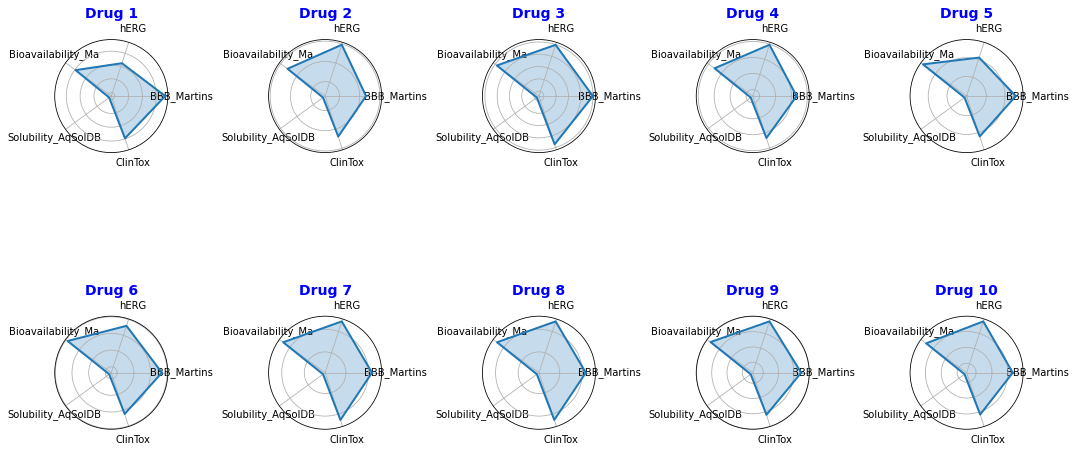

In [39]:
categories = ['BBB_Martins', 'hERG', 'Bioavailability_Ma', 'Solubility_AqSolDB', 'ClinTox']

# Extract the DataFrame for Cluster_1 and the top 10 drugs based on their index
top_10_drugs_df = ADMET_clusters_dataframes_gagpol['Cluster_1'].iloc[top_10_index]


fig, ax = plt.subplots(2, 5, figsize=(15, 8), subplot_kw=dict(polar=True))

for i in range(10):
    row = i // 5  
    col = i % 5  
    
    sbpl = ax[row, col]  

    values = [
        top_10_drugs_df.iloc[i]['BBB_Martins'],
        top_10_drugs_df.iloc[i]['hERG'],
        top_10_drugs_df.iloc[i]['Bioavailability_Ma'],
        top_10_drugs_df.iloc[i]['Solubility_AqSolDB'],
        top_10_drugs_df.iloc[i]['ClinTox']
    ]
    

    num_vars = len(categories)
    
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    
    values += values[:1]
    angles += angles[:1]

    sbpl.plot(angles, values, linewidth=2, linestyle='solid', label=f'Drug {i+1}')
    
    sbpl.fill(angles, values, alpha=0.25)
    
    sbpl.set_yticklabels([])  
    sbpl.set_xticks(angles[:-1])  
    sbpl.set_xticklabels(categories, fontsize=10)

    sbpl.set_title(f'Drug {i+1}', size=14, color='blue', weight='bold')

plt.tight_layout()
plt.show()


In [40]:

categories = ['BBB_Martins', 'hERG', 'Bioavailability_Ma', 'Solubility_AqSolDB', 'ClinTox']

# Extract the DataFrame for Cluster_1 and the top 10 drugs based on their index
top_10_drugs_df = ADMET_clusters_dataframes_gagpol['Cluster_1'].iloc[top_10_index]

fig = sp.make_subplots(rows=2, cols=5, subplot_titles=[f'Drug {i+1}' for i in range(10)],
                    specs=[[{'type': 'polar'}] * 5, [{'type': 'polar'}] * 5])

for i in range(10):
    values = [
        top_10_drugs_df.iloc[i]['BBB_Martins'],
        top_10_drugs_df.iloc[i]['hERG'],
        top_10_drugs_df.iloc[i]['Bioavailability_Ma'],
        top_10_drugs_df.iloc[i]['Solubility_AqSolDB'],
        top_10_drugs_df.iloc[i]['ClinTox']
    ]
    
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    values += values[:1]  
    angles += angles[:1]

    fig.add_trace(
        go.Scatterpolar(
            r=values,
            theta=categories + [categories[0]],  
            name=f'Drug {i+1}'
        ),
        row=i // 5 + 1, col=i % 5 + 1  
    )

fig.update_layout(
    height=800,
    width=1200,
    title_text="Radar Plots of ADMET Properties for Top 10 Drugs",
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1],  
            showticklabels=True
        )
    ),
    template="plotly_dark",  
)

fig.write_html("radar_plots_top_10_drugs.html")

fig.show()




### Visualization of 5 sample drugs from each cluster

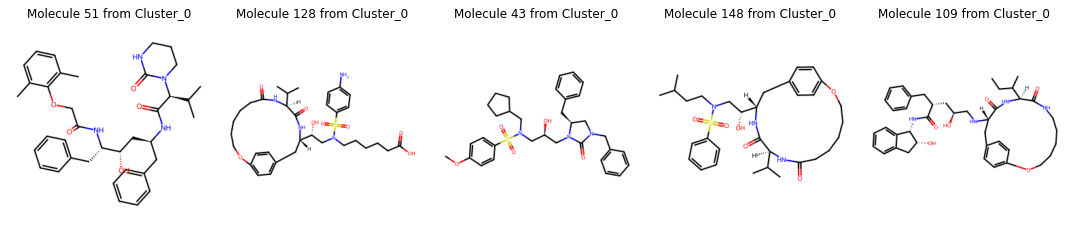

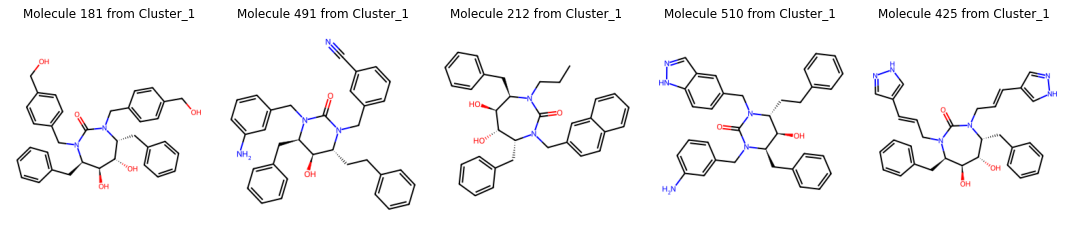

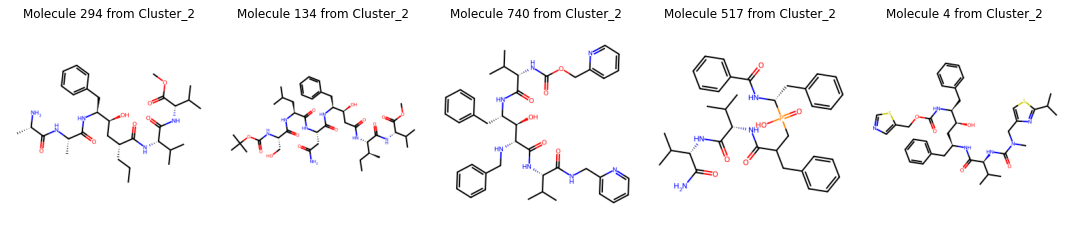

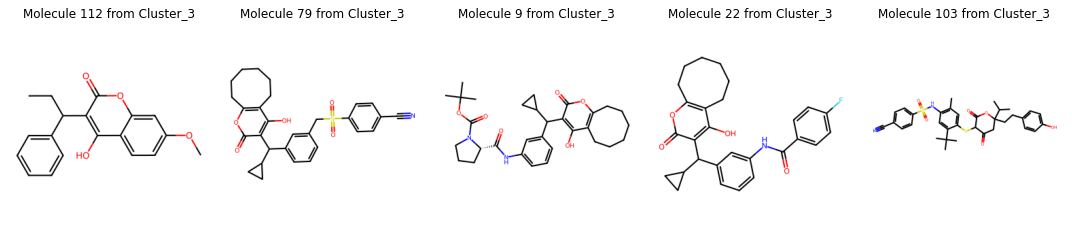

In [42]:
visualize_drugs(gagpol_cluster_df, 'Cluster_0')
visualize_drugs(gagpol_cluster_df, 'Cluster_1')
visualize_drugs(gagpol_cluster_df, 'Cluster_2')
visualize_drugs(gagpol_cluster_df, 'Cluster_3')